<a href="https://colab.research.google.com/github/KonstantinaT/Predictor/blob/main/Comparison500AA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Comparison of Pre-trained representations and GMM distances features with FCNN and RNN respectively


## Libraries, Classes and Functions

In [1]:
import csv
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import math
import gc
import warnings
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.metrics import matthews_corrcoef
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, TensorDataset
from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from numpy import asarray,savez_compressed
pd.set_option("display.max_rows", None, "display.max_columns", None)
!pip install -q SentencePiece transformers
from transformers import AdamW, get_cosine_schedule_with_warmup, get_linear_schedule_with_warmup, T5EncoderModel, T5Tokenizer
import torch.nn as nn
from torch.optim import lr_scheduler
from torch.nn.utils.rnn import pad_sequence
import requests
import warnings
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
from sklearn import metrics
#from torch.utils import data
import re
import os
!pip install Biopython

     |████████████████████████████████| 1.2 MB 7.3 MB/s 
     |████████████████████████████████| 4.7 MB 55.3 MB/s 
     |████████████████████████████████| 101 kB 13.0 MB/s 
     |████████████████████████████████| 596 kB 79.0 MB/s 
     |████████████████████████████████| 6.6 MB 41.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.3 MB 8.0 MB/s 


In [2]:
class Classifier(nn.Module):
    def __init__(self, hidden, dropout=0):
        super(Classifier, self).__init__()
        self.hidden = hidden
        self.num_feature = 500
        self.dropout = dropout
        self.batchnorm1 = nn.BatchNorm1d(self.hidden)

        self.layer_1 = nn.Linear(self.num_feature,  self.hidden)
        self.layer_2 = nn.Linear( self.hidden, 1)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        #x = self.batchnorm2(x)
        #x = self.sigmoid(x)
        
        return x

    def compute_l1_loss(self, w):
        return torch.abs(w).sum()

    def compute_l2_loss(self, w):
        return torch.square(w).sum()

In [3]:
# evaluates the performance of a model and return the predictions and ground truth
def eval(model, loader):
    model.eval()
    outputs = []
    predictions = []
    for i, batch in enumerate(loader):
        sequences = batch[0].to(device)
        output = batch[1].to(device)
        output = output.flatten()
        prediction = model(sequences)

        prediction = torch.round(prediction.squeeze()).flatten()  # rounds to the nearest integer

        predictions.append(prediction.detach().cpu().numpy())
        outputs.append(output.detach().cpu().numpy())
    
    return np.hstack(predictions), np.hstack(outputs)


# implementation of a single training epoch
def train_epoch(net, loader, loss_fn, optimizer, scheduler):
    
    # set the network in training mode
    net.train()
    
    # keep track of the loss
    loss_cum = 0
    cnt = 0
    num_correct = 0
    targets = []
    predictions = []
    
    for i, data in enumerate(loader): 
        
        # sample data
        x, y, i = data
        x = x.to(device)
        y = y.to(device)
        
        # set all gradients equal to zero
        net.zero_grad()
        
        # feed the batch to the network and compute the outputs
        y_pred = net(x.float())
        #y_pred_sq = np.squeeze(y_pred) # add when using loss_fn: BCEloss()
        
        pred = torch.round(y_pred.squeeze())  # rounds to the nearest integer
  
        # compare predictions to true label
        #correct_tensor = pred.eq(y.float().view_as(pred))
        #correct = np.squeeze(correct_tensor.cpu().numpy())
        #num_correct += np.sum(correct)
        targets.extend(y.cpu().detach().numpy().tolist())
        predictions.extend(torch.sigmoid(y_pred).cpu().detach().numpy().tolist())

        #predictions_round = [round(p) for p in predictions]
        #correct_tensor = predictions_round.eq(targets.float().view_as(predictions_round))

        #loss = loss_fn(y_pred_sq, y.float())  #add when using loss_fn: BCEloss()
        loss = loss_fn(y_pred, y.float())

        # Specify L1 and L2 weights
        l1_weight = 0
        l2_weight = 0
        
        # Compute L1 and L2 loss component
        parameters = []
        for parameter in net.parameters():
            parameters.append(parameter.view(-1))
        l1 = l1_weight * net.compute_l1_loss(torch.cat(parameters))
        l2 = l2_weight * net.compute_l2_loss(torch.cat(parameters))
        
        # Add L1 and L2 loss components
        loss += l1
        loss += l2

        loss_cum += loss.data.cpu().numpy()
        cnt += 1

        # backpropagate the gradients w.r.t. computed loss
        loss.backward()

        # apply one step in the optimization
        optimizer.step()
        scheduler.step()
        
        #break #for training one batch
          
    # compute the average loss
    #mytrain_acc = num_correct 
    loss_avg = loss_cum / cnt

    #predictions = np.array(predictions) >= 0.5
    predictions = [1 if p[0] > 0.5 else 0 for p in predictions]
    mytrain_acc  = metrics.accuracy_score(targets, predictions)   *100
    #mytrain_acc = (num_correct/ (len(y)*cnt)) *100

    return loss_avg, mytrain_acc

def loss_fn(outputs, targets):
  return nn.BCEWithLogitsLoss()(outputs, targets.view(-1, 1))

In [4]:
# implementation of a single testing epoch
def test_epoch(net, loader, loss_fn):
    
    # set the network in evaluation mode
    net.eval()
    
    # keep track of the loss
    loss_cum = 0
    cnt = 0
    num_correct_val = 0
    targets = []
    predictions = []
    with torch.no_grad():
      for i, data in enumerate(loader): 

          x, y = data
          x = x.to(device)
          y = y.to(device)
          
          # feed the batch to the network and compute the outputs
          y_pred = net(x.float())
          #y_pred_sq = np.squeeze(y_pred) #add when using loss_fn: BCEloss()
          pred = torch.round(y_pred.squeeze())  # rounds to the nearest integer
          
          # compare predictions to true label
          #correct_tensor = pred.eq(y.float().view_as(pred))
          #correct = np.squeeze(correct_tensor.cpu().numpy())
          
          targets.extend(y.cpu().detach().numpy().tolist())
          predictions.extend(torch.sigmoid(y_pred).cpu().detach().numpy().tolist())

          #num_correct_val += np.sum(correct)
          # compare the outputs to the labels with the loss function
          #loss = loss_fn(y_pred_sq, y.float())  #ad|d when using loss_fn: BCEloss()
          loss = loss_fn(y_pred, y.float())

          # Specify L1 and L2 weights
          l1_weight = 0
          l2_weight = 0
          
          # Compute L1 and L2 loss component
          parameters = []
          for parameter in net.parameters():
              parameters.append(parameter.view(-1))
          l1 = l1_weight * net.compute_l1_loss(torch.cat(parameters))
          l2 = l2_weight * net.compute_l2_loss(torch.cat(parameters))
          
          # Add L1 and L2 loss components
          loss += l1
          loss += l2
            
          loss_cum += loss.data.cpu().numpy()
          cnt += 1
          
    # compute the average loss
    #len_trainx = len(loader) * len(y_pred)
    #mytest_acc = num_correct_val 
    loss_avg = loss_cum / cnt
    predictions = np.array(predictions) >= 0.5
    mytest_acc  = (metrics.accuracy_score(targets, predictions)) *100
    
    return loss_avg, mytest_acc




def train_net(net, train_loader, loss_fn, optimizer, epochs , scheduler):
    
    # transfer the network to the GPU
    net = net.to(device)
    
    train_loss = np.zeros((epochs))
    test_loss = np.zeros((epochs))
    train_acc = np.zeros((epochs))
    train_acc_alt = np.zeros((epochs))
    
    test_acc = np.zeros((epochs))
    test_acc_alt = np.zeros((epochs))
    
    print("Begin training.")

    for epoch in tqdm(range(epochs)):
        
        # training
        train_loss[epoch], train_acc[epoch] = train_epoch(net, train_loader, loss_fn, optimizer, scheduler)
        #predictions, outputs = eval(net, train_loader)
        #train_acc_alt[epoch] = metrics.accuracy_score(outputs, predictions)

        # validation
        #test_loss[epoch], test_acc[epoch] = test_epoch(net, val_loader, loss_fn)
        #predictions, outputs = eval(net, val_loader)
        #test_acc_alt[epoch] = metrics.accuracy_score(outputs, predictions)
        
        #print('Epoch %5d - Train loss: %.6f - Train accuracy: %.6f - Test loss: %.6f - Test accuracy: %.6f' 
        #     % (epoch, train_loss[epoch], train_acc[epoch], test_loss[epoch], test_acc[epoch]))

    #return (train_loss, test_loss), (train_acc , test_acc)
    return train_loss, train_acc # for training one batch

In [5]:
# First checking if GPU is available
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')

Training on GPU.


In [6]:
class toyRNN(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """

    def __init__(self, output_size, hidden_dim, n_layers):
        """
        Initialize the model by setting up the layers.
        """
        super(toyRNN, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        in_channels = 1

        self.gru = nn.GRU(in_channels, hidden_dim, n_layers, batch_first=True)
        
        # dropout layer
        self.dropout = nn.Dropout(0.4)
        # linear and sigmoid layers
        self.fc = nn.Linear(hidden_dim, output_size)
        nn.init.xavier_normal_(self.fc.weight)
        self.sig = nn.Sigmoid()

         
    def forward(self, x, hidden, test_var=False):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)  
        # embeddings and lstm_out
        #print('hidden', hidden[0].size())

        lstm_out, hidden = self.gru(x, hidden)
       
        # stack up lstm outputs
        lstm = lstm_out.contiguous().view(-1, self.hidden_dim)
        # dropout and fully-connected layer
        out = self.dropout(lstm)
        
        # dropout and fully-connected layer
        out = self.fc(out)
        # sigmoid function
        sig_out = self.sig(out)

        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # get last batch of labels
        if test_var == True:
          return lstm_out
        # return last sigmoid output and hidden state
        else:
          return sig_out , hidden


    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim).cuda()

        return hidden

In [7]:
def dataset_with_indices(cls):
    """
    Modifies the given Dataset class to return a tuple data, target, index
    instead of just data, target.
    """

    def __getitem__(self, index):
        data, target = cls.__getitem__(self, index)
        return data, target, index

    return type(cls.__name__, (cls,), {
        '__getitem__': __getitem__,
    })


DWithInd = dataset_with_indices(torch.utils.data.TensorDataset)

In [8]:
def Average(lst):
  return sum(lst) /len(lst)

In [9]:
def get_class_distribution_binary(obj):
    count_dict = {
        'Neutral': 0,
        'Deleterious': 0,
    }
    
    for i in obj:
        if i == 0: 
            count_dict['Neutral'] += 1
        elif i == 1: 
            count_dict['Deleterious'] += 1
        
        else:
            print("Check classes.")
            
    return count_dict

In [10]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

In [11]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [12]:
def unique(list1):
 
    # initialize a null list
    unique_list = []
     
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)

    print(f'{len(unique_list)} unique transcripts')
    return unique_list

In [13]:
def init_weights(m):
    if type(m) == nn.Linear:
        #nn.init.normal_(m.weight, std=0.01) 
        nn.init.xavier_normal_(m.weight)

    if type(m) == nn.LSTM:
      for param in m._flat_weights_names:
          if "weight" in param:
              nn.init.xavier_uniform_(m._parameters[param])

In [14]:
class LSTM(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """

    def __init__(self, output_size, hidden_dim, n_layers):
        """
        Initialize the model by setting up the layers.
        """
        super(LSTM, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        in_channels = 1

        #self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
        #                    batch_first=True, bidirectional=True)
        self.lstm = nn.LSTM(in_channels, hidden_dim,
                            n_layers, batch_first=True, bidirectional=True)
        
        
        # dropout layer
        self.dropout = nn.Dropout(0.4)
        # linear and sigmoid layers
        self.fc = nn.Linear(hidden_dim, output_size)
        nn.init.xavier_normal_(self.fc.weight)
        self.sig = nn.Sigmoid()

         
    def forward(self, x, hidden, test_var=False):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)  
        # embeddings and lstm_out
        #print('hidden', hidden[0].size())

        lstm_out, hidden = self.lstm(x, hidden)
       
        # stack up lstm outputs
        lstm = lstm_out.contiguous().view(-1, self.hidden_dim)
        # dropout and fully-connected layer
        out = self.dropout(lstm)
        
        # dropout and fully-connected layer
        out = self.fc(out)
        # sigmoid function
        sig_out = self.sig(out)

        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # get last batch of labels
        if test_var == True:
          return lstm_out
        # return last sigmoid output and hidden state
        else:
          return sig_out , hidden


    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data

        if (train_on_gpu):
            #hidden = (weight.new(self.n_layers*2, batch_size, self.hidden_dim).zero_().cuda())
            hidden = (weight.new(self.n_layers*2, batch_size, self.hidden_dim).zero_().cuda(),
                      weight.new(self.n_layers*2, batch_size, self.hidden_dim).zero_().cuda())
            #nn.init.xavier_normal_(hidden)
        else:
            hidden = (weight.new(self.n_layers*2, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers*2, batch_size, self.hidden_dim).zero_())

        return hidden

## Load Prot t5 Model 

In [ ]:
# Advanced
tokenizer = T5Tokenizer.from_pretrained("Rostlab/prot_t5_xl_uniref50", do_lower_case=False )
model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_uniref50")
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model = model.eval()
gc.collect()

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.74k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/546 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.5G [00:00<?, ?B/s]

Some weights of the model checkpoint at Rostlab/prot_t5_xl_uniref50 were not used when initializing T5EncoderModel: ['decoder.block.9.layer.2.layer_norm.weight', 'decoder.block.23.layer.0.layer_norm.weight', 'decoder.block.10.layer.0.SelfAttention.v.weight', 'decoder.block.3.layer.2.DenseReluDense.wo.weight', 'decoder.block.21.layer.2.DenseReluDense.wi.weight', 'decoder.block.18.layer.2.layer_norm.weight', 'decoder.block.14.layer.2.DenseReluDense.wi.weight', 'decoder.block.17.layer.1.EncDecAttention.k.weight', 'decoder.block.22.layer.1.EncDecAttention.o.weight', 'decoder.block.18.layer.1.layer_norm.weight', 'decoder.block.18.layer.0.SelfAttention.k.weight', 'decoder.block.12.layer.2.DenseReluDense.wi.weight', 'decoder.block.11.layer.0.SelfAttention.k.weight', 'decoder.block.0.layer.1.layer_norm.weight', 'decoder.block.12.layer.2.layer_norm.weight', 'decoder.block.11.layer.0.SelfAttention.o.weight', 'decoder.block.0.layer.2.DenseReluDense.wi.weight', 'decoder.block.4.layer.2.layer_norm.

1044

## Prot t5 example

In [ ]:
# Example
sequences_Example = ["A E T C A K","S K K P"]
#sequences_Example = ["A E T C A K"]
#sequences_Example = [seq_spaced[0]]
#sequences_Example = [seq_spaced[50]]
#print(sequences_Example)
sequences_Example = [re.sub(r"[UZOB]", "X", sequence) for sequence in sequences_Example]
example_ids = tokenizer.batch_encode_plus(sequences_Example, padding="longest") # The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
example_input_ids = torch.tensor(example_ids['input_ids']).to(device)
example_attention_mask = torch.tensor(example_ids['attention_mask']).to(device)

with torch.no_grad():
    example_embedding = model(input_ids=example_input_ids,attention_mask=example_attention_mask)
example_embedding = example_embedding.last_hidden_state.cpu().numpy()
print(example_embedding.shape)

example_features = [] 
for seq_num in range(len(example_embedding)):
    seq_len = (example_attention_mask[seq_num] == 1).sum()
    seq_emd_example = example_embedding[seq_num][:seq_len-1]
    #seq_emd_example = example_embedding[seq_num]
    print(seq_emd_example.shape)
    example_features.append(seq_emd_example)
### feature: a list of lists, dimensions: number of sequences given as input. Dimensions of each list: number of AminoAcid per sequence. Each of those have an embedding of 1024 dimensions

(2, 7, 1024)
(6, 1024)
(4, 1024)


## Pre-Trained only + FCNN

### Import Tier1_2_3_humsavar, keep < 500AA and those for which I have calculated the GMM for comparison

In [15]:
all_mutations =pd.read_csv('/content/drive/MyDrive/my_colab/3rdYear/datasets/Tier1_2_3_CGI_humsavar.csv')
all_mutations = all_mutations.sort_values(by='uniprot') 

In [16]:
len(all_mutations)

10263

exclude >500AA

In [17]:
all_mutations = all_mutations.reset_index(drop=True)

ind_excl =[]
for i, mut in all_mutations.iterrows():
  if len(mut['mut_sequence']) > 500:
    ind_excl.append(i)

mutations500AA = all_mutations.drop(all_mutations.index[ind_excl])
mutations500AA = mutations500AA.reset_index(drop=True)

In [18]:
# load GMM mutations
GMM_500mut = pd.read_csv('/content/drive/MyDrive/log_probWT_MUT_Tier1_2_3_CGI_humsavar500AA_filtermix3517.csv', header = None, names = ['mutation', 'log_difference', 'label'])
GMM_500mut = GMM_500mut.reset_index(drop=True)

# exclude duplicates
GMM_500mut.drop_duplicates(subset = 'mutation', inplace =True)

print(f'GMM done for {len(GMM_500mut)} mutations smaller than 501AA')
mutations = GMM_500mut['mutation'].values

ind_excl = [] # not calculated with GMM
k=0
for i, mut in mutations500AA.iterrows():
  if mut['uniprot'] + '_' + mut['AA_orig'] + str(mut['position']) + mut['AA_targ'] not in mutations:
    #print(mut['uniprot'] + '_' + mut['AA_orig'] + str(mut['position']) + mut['AA_targ'])
    k+=1
    ind_excl.append(i)

mutations500AAfin = mutations500AA.drop(mutations500AA.index[ind_excl])
mutations500AAfin = mutations500AAfin.reset_index(drop=True)

GMM done for 2162 mutations smaller than 501AA


In [19]:
seq_all =[]
for i, mut in mutations500AAfin.iterrows():
  seq_all.append(mut['mut_sequence'])

In [20]:
# Add spaces between Amino Acids
seq_spaced = []
for seq_single in seq_all:
  temp = " ".join(seq_single)
  seq_spaced.append(temp)
len_sequences = len(seq_spaced)

### Calculate Pro t5 representations

In [ ]:
indices_to_excl = []
seq_pooled = []
count=0
BATCH_FILE_SIZE = 2000
for i in seq_spaced:
    count+=1
    #print('Length of sequence', len(i) )
    ids = tokenizer.batch_encode_plus([i], add_special_tokens=True, padding='longest')
    input_ids = torch.tensor(ids['input_ids']).to(device)
    attention_mask = torch.tensor(ids['attention_mask']).to(device)
    try:
        with torch.no_grad():
            embedding = model(input_ids=input_ids,attention_mask=attention_mask)
        embedding = embedding.last_hidden_state.cpu().numpy()
        
        for seq_num in range(len(embedding)):
            seq_len = (attention_mask[seq_num] == 1).sum()
            seq_emd = embedding[seq_num][:seq_len-1]
            # seq_emd = embedding[seq_num]
            # print('After cropping: ', seq_emd.shape)
            seq_temp = torch.tensor(seq_emd)
            #seq_emd_pooled = m(seq_temp)
            #print('After maxpooling:', seq_emd_pooled.shape)
        
        seq_pooled.append(seq_temp)
        
        if not count % BATCH_FILE_SIZE:
            print('Count is:', count)
            print('Seq_pooled size is:', len(seq_pooled))
            with open(f'/content/drive/MyDrive/my_colab/3rdYear/GMM/prott5_Tier1_2_3_humsavar_500AA_{int(count/BATCH_FILE_SIZE)}.pickle', 'wb') as handle:
                print('count/batch:' , int(count/BATCH_FILE_SIZE))
                pickle.dump(seq_pooled, handle)
            seq_pooled = []
        
    except:
        indices_to_excl.append(count - 1)


if count % BATCH_FILE_SIZE: # for last sequences 
    with open(f'/content/drive/MyDrive/my_colab/3rdYear/GMM/prott5_Tier1_2_3_humsavar_500AA_{math.ceil(count/BATCH_FILE_SIZE)}.pickle', 'wb') as handle:
        pickle.dump(seq_pooled, handle)  
print(len(seq_pooled))


with open('/content/drive/MyDrive/my_colab/3rdYear/GMM/prott5_Tier1_2_3_humsavar_500AA_indices_to_excl.pickle', 'wb') as handle:
    pickle.dump(indices_to_excl, handle)

Count is: 2000
Seq_pooled size is: 2000
count/batch: 1
162


### Load Prot5 representations

In [20]:
seq_all_nocrop = []

for k in [x for x in range(1, 3)]:# if x != 11]:
  with open(f'/content/drive/MyDrive/my_colab/3rdYear/GMM/prott5_Tier1_2_3_humsavar_500AA_{k}.pickle','rb') as file_handle:
    file_temp = pickle.load(file_handle) # load the sequences of one batch (2000)

    seq_temp = []
    for seq in file_temp:
      AA_seq_temp = []
      for AA in seq:
        AA_seq_temp.append(torch.mean(AA))
      seq_temp.append(AA_seq_temp)
    seq_all_nocrop = seq_all_nocrop + seq_temp

# Crop to 1500 AA, pad shorter ones to 2000 AA
seq_all_cropped = []
for seq_single in seq_all_nocrop:
  seq_single = torch.tensor(seq_single)
  #if len(seq_single) > 500:
  #    seq_all_cropped.append(seq_single[:500])
  #else:
  to_pad = 500 - len(seq_single) 
  seq_all_cropped.append(F.pad(input=seq_single, pad=(0, to_pad), mode='constant', value=0))

gc.collect()
seq_cropped_flat = []
for i in seq_all_cropped:
  seq_cropped_flat.append(torch.flatten(i))

stacked_tensor_flat = torch.stack(seq_cropped_flat)
print(stacked_tensor_flat.shape)

torch.Size([2162, 500])


(array([2.90000e+01, 5.01000e+02, 6.37300e+03, 5.95370e+04, 2.45251e+05,
        6.66419e+05, 9.12310e+04, 1.10020e+04, 6.30000e+02, 2.70000e+01]),
 array([-0.03380194, -0.02729196, -0.02078197, -0.01427199, -0.007762  ,
        -0.00125202,  0.00525797,  0.01176795,  0.01827794,  0.02478792,
         0.03129791], dtype=float32),
 <a list of 10 Patch objects>)

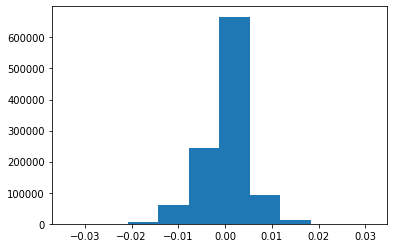

In [21]:
repre_reshape = torch.reshape(stacked_tensor_flat,[-1])
plt.hist(repre_reshape)

(array([[ 7.,  2., 10., ..., 28.,  4.,  0.],
        [ 7.,  6., 18., ..., 39., 15.,  5.],
        [ 7.,  6., 18., ..., 40., 14.,  5.],
        ...,
        [ 7.,  8., 30., ..., 34., 18., 12.],
        [ 5.,  4., 12., ..., 29., 12.,  4.],
        [ 6.,  2.,  7., ...,  8.,  1.,  0.]]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 2162 Lists of Patches objects>)

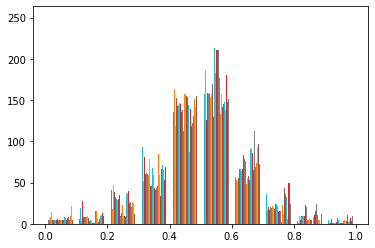

In [22]:
# Normalize
scaler = MinMaxScaler() 
stacked_tensor_flat = scaler.fit_transform(stacked_tensor_flat)
stacked_tensor_flat = torch.tensor(stacked_tensor_flat)
plt.hist(stacked_tensor_flat)

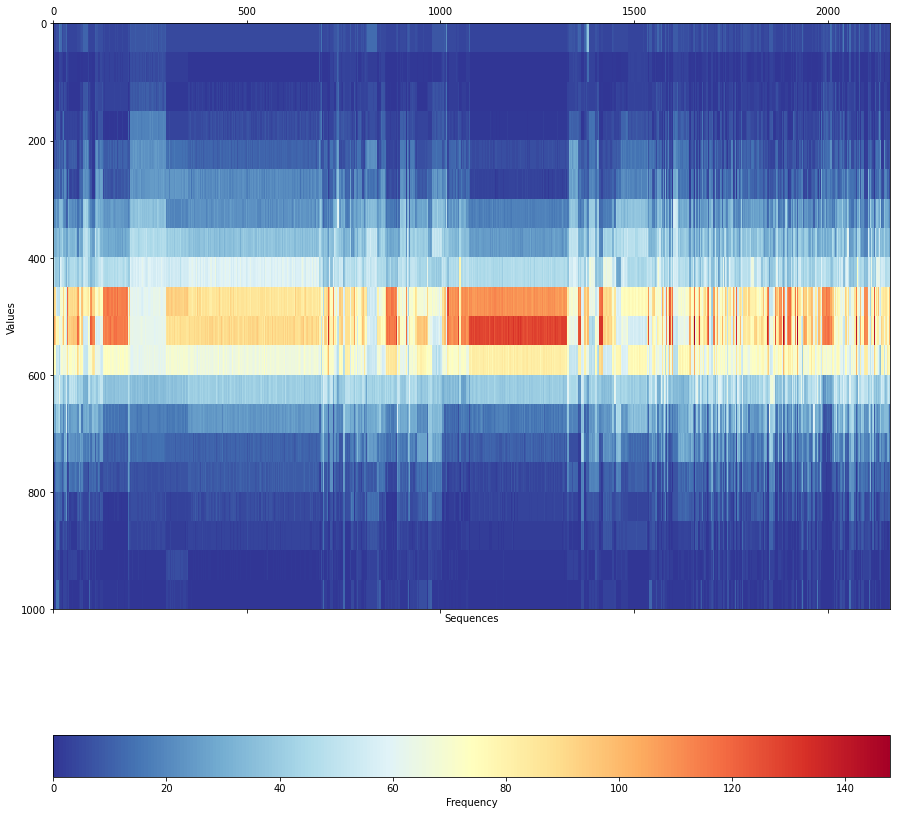

In [79]:
Nphase = 2162
Npoints = 500

phase = np.linspace(0.,1.,num=Nphase)

#calculate the bins we're going to use
minBin, maxBin = np.nanmin(stacked_tensor_flat)*1000,np.nanmax(stacked_tensor_flat*1000)
Nbins = 20

binedData = np.zeros((Nphase,Nbins))
for i,a in enumerate(stacked_tensor_flat*1000):
    binedData[i,:], bins = np.histogram(a[~np.isnan(a)],bins=Nbins,range=(minBin,maxBin))

plt.figure(figsize=(15,15))
plt.matshow(binedData.T, cmap=plt.cm.RdYlBu_r, extent=(0,Nphase,maxBin,minBin), fignum=1, aspect='auto')

plt.grid(False)
c = plt.colorbar(orientation='horizontal')
plt.xlabel('Sequences')
plt.ylabel('Values')
c.set_label('Frequency')
plt.show()

### Visualization

In [ ]:
with open(f'/content/drive/MyDrive/my_colab/3rdYear/GMM/prott5_Tier1_2_3_humsavar_500AA_1.pickle','rb') as file_handle:
  	file_temp = pickle.load(file_handle) # load the sequences of one batch (2000)

In [ ]:
torch.set_printoptions()

In [ ]:
seq = file_temp[0]
len(seq)

238

In [ ]:
mutations500AAfin.head()

,uniprot,mut_sequence,AA_orig,position,AA_targ,label
0,A0PJX4-1,MRALLALCLLLGCLRWGPAGAQQSGEYCHGWVDVQGNYHEGFQCPE...,W,13,C,1
1,A4D1S0-1,MEESWEAAPGGQAGAELPMEPVGSLVPTLEQPQVPAKVRQPEGPES...,G,339,A,0
2,A4D1S0-1,MEESWEAAPGGQAGAELPMEPVGSLVPTLEQPQVPAKVRQPEGPES...,K,152,T,1
3,A6ND91-1,MADRGPWRVGVVGYGRLGQSLVSRLLAQGPELGLELVFVWNRDPGR...,Q,266,R,1
4,A6NDP7-1,MGSTMEPPGGAYLHLGAVTSPVGTARVLQLAFGCTTFSLVAHRGGF...,S,116,P,1


In [ ]:
# UMAP
!pip install umap-learn
import umap.umap_ as umap
import seaborn as sns

reducer = umap.UMAP()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 3.4 MB/s 
     |████████████████████████████████| 1.1 MB 27.0 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=7970543e29ed451fea35c173c892d5f20baae0dfa593fab9378877f2717916cd
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=1922c5ea224a9e6d3b6d7b32f306c378d7f40eb390254b04639baa8623e7570c
  Stored in directory: /root/.cache/pip/wheels/7f/2a/f8/7bd5dcec71bd5c669f6f574db3113513696b98f3f9b51f496c
Successfully built umap-learn pynndescent


In [ ]:
embedding = reducer.fit_transform(seq) # (words, representation_dimension0
print(embedding.shape)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


(238, 2)


In [ ]:
data = pd.DataFrame(embedding,columns=['emb1', 'emb2'])

In [ ]:
data['AA'] = list(mutations500AAfin.iloc[0]['mut_sequence'])

In [ ]:
data['position']= range(1, len(mutations500AAfin.iloc[0]['mut_sequence'])+1)

In [ ]:
# Before running this cell add #defaults = yaml.load(f) defaults = yaml.safe_load(f) at: /usr/local/lib/python3.7/dist-packages/distributed/config.py 
import plotly.express as px

fig = px.scatter(data, x="emb1", y="emb2", color="AA", hover_data=['position'])
fig.show()

###Training

In [81]:
dataset = DWithInd(stacked_tensor_flat, torch.from_numpy(mutations500AAfin['label'].values))
# run all computations on the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Running computations with %s' % torch.device(device))
if torch.cuda.is_available():
    print(torch.cuda.get_device_properties(device))

Running computations with cuda
_CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)


In [ ]:
# Configurationh options
k_folds = 10
num_epochs = 50
#loss_function = nn.CrossEntropyLoss()
loss_function = nn.BCEWithLogitsLoss()

# For fold results
results, sensitivity, specificity = {}, {}, {}

# Set fixed random number seed
torch.manual_seed(42)

# Define the K-fold Cross Validator
kfold = StratifiedKFold(n_splits=k_folds, shuffle=True)
  
# Start print
print('--------------------------------')

# K-fold Cross Validation model evaluation
for fold, (train_ids, test_ids) in enumerate(kfold.split(stacked_tensor_flat, mutations500AAfin['label'].to_numpy())):
  
  # Print
  print(f'FOLD {fold}')
  print('--------------------------------')
  
  # Sample elements randomly from a given list of ids, no replacement.
  train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
  test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
  
  # Define data loaders for training and testing data in this fold
  trainloader = torch.utils.data.DataLoader(
                    dataset, 
                    batch_size=34, sampler=train_subsampler)
  testloader = torch.utils.data.DataLoader(
                    dataset,
                    batch_size=34, sampler=test_subsampler)
  
  # Init the neural network
  network = Classifier(128).to(device)
  network.apply(init_weights)
  
  # Initialize optimizer
  optimizer = torch.optim.Adam(network.parameters(), lr=1e-4)
  
  # Run the training loop for defined number of epochs
  for epoch in range(0, num_epochs):

    # Print epoch
    #print(f'Starting epoch {epoch+1}')

    # Set current loss value
    current_loss = 0.0

    # Iterate over the DataLoader for training data
    for i, data in enumerate(trainloader, 0):
      
      # Get inputs
      inputs, targets, ind = data
      if(train_on_gpu):
        inputs, targets, ind = inputs.cuda(), targets.cuda(), ind.cuda()
      # Zero the gradients
      optimizer.zero_grad()
      
      # Perform forward pass

      outputs = network(inputs.float())
      outputs= outputs.squeeze()
      
      # Compute loss
      loss = loss_function(outputs, targets.float())
      
      # Perform backward pass
      loss.backward()
      
      # Perform optimization
      optimizer.step()
      
      # Print statistics
      current_loss += loss.item()
      if i % 500 == 499:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 500))
          current_loss = 0.0
          
  # Process is complete.
  #print('Training process has finished. Saving trained model.')

  # Print about testing
  print('Starting testing')
  
  # Saving the model
  #save_path = f'./model-fold-{fold}.pth'
  #torch.save(network.state_dict(), save_path)

  # Evaluationfor this fold
  correct, total = 0, 0
  outputs_fold, targets_fold =[], []

  network.eval()
  with torch.no_grad():

    # Iterate over the test data and generate predictions
    for i, data in enumerate(testloader, 0):
     
      # Get inputs
      inputs, targets, ind = data
      
      if(train_on_gpu):
        inputs, targets, ind = inputs.cuda(), targets.cuda(), ind.cuda()
      # Generate outputs
      outputs = network(inputs.float())
      outputs_fold.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
      targets_fold.extend(targets.cpu().detach().numpy().tolist())

      # Set total and correct
      #_, predicted = torch.max(outputs.data, 1)

      #print(torch.round(torch.sigmoid(outputs)))
      #print(targets)
      total += targets.size(0)
      #correct += (torch.round(torch.sigmoid(outputs)) == targets).sum().item()
      outputs_round = torch.round(torch.sigmoid(outputs))
      correct += (outputs_round.eq(targets.float().view_as(outputs_round))).sum()

    # Print accuracy
    print('Accuracy for fold %d: %d %%' % (fold, 100.0 * correct / total))
    print('--------------------------------')
    results[fold] = 100.0 * (correct / total)

    flat_list = []
    for sublist in outputs_fold:
        for item in sublist:
            flat_list.append(item)

    predictions = [1 if i>0.5 else 0 for i in flat_list]
    confusion_matrix_df = pd.DataFrame(confusion_matrix(targets_fold, predictions))
    tn, fp, fn, tp = confusion_matrix(targets_fold, predictions).ravel()

    #print(classification_report(targets_fold, predictions))
    #print(tp, tn, fp, fn )

    TPR =tp / (tp + fn)
    #print('Sensitivity: %.2f'  % (TPR*100))
    sensitivity[fold] = TPR*100

    TNR = tn / (tn + fp)
    #print('Specificity: %.2f'  % (TNR*100))
    specificity[fold] = TNR*100

    network.train()

  
# Print fold results
print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
print('--------------------------------')
print('Accuracy:')
sum = 0.0
for key, value in results.items():
  print(f'Fold {key}: {torch.round(value)} %')
  sum += value
print(f'Average: {torch.round(sum/len(results.items()))} %\n')

print('Sensitivity:')
sum = 0.0
for key, value in sensitivity.items():
  print(f'Fold {key}:  {round(value, 2)}  %')
  sum += value
print(f'Average: {round(sum/len(results.items()),2)} %\n')

print('Specificity:')
sum = 0.0
for key, value in specificity.items():
  print(f'Fold {key}: {round(value, 2)}  %')
  sum += value
print(f'Average: {round(sum/len(results.items()),2)} %')

--------------------------------
FOLD 0
--------------------------------
Starting testing
Accuracy for fold 0: 89 %
--------------------------------
FOLD 1
--------------------------------
Starting testing
Accuracy for fold 1: 85 %
--------------------------------
FOLD 2
--------------------------------
Starting testing
Accuracy for fold 2: 82 %
--------------------------------
FOLD 3
--------------------------------
Starting testing
Accuracy for fold 3: 83 %
--------------------------------
FOLD 4
--------------------------------
Starting testing
Accuracy for fold 4: 81 %
--------------------------------
FOLD 5
--------------------------------
Starting testing
Accuracy for fold 5: 81 %
--------------------------------
FOLD 6
--------------------------------
Starting testing
Accuracy for fold 6: 84 %
--------------------------------
FOLD 7
--------------------------------
Starting testing
Accuracy for fold 7: 84 %
--------------------------------
FOLD 8
--------------------------------

--------------------------------
FOLD 0
--------------------------------
Begin training.


  0%|          | 0/100 [00:00<?, ?it/s]

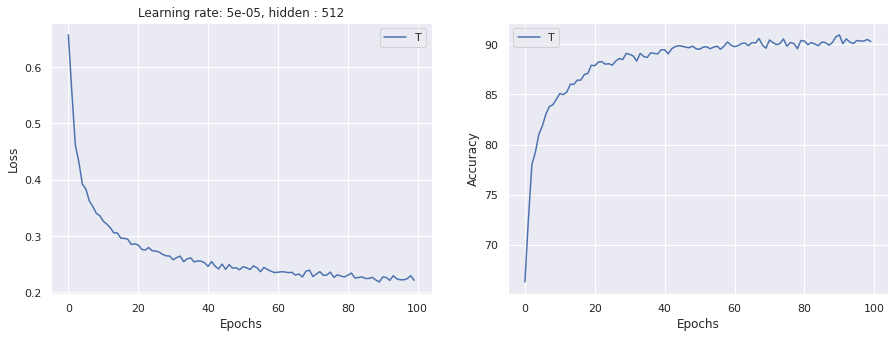

Accuracy for fold 0: 79 %
--------------------------------
FOLD 1
--------------------------------
Begin training.


  0%|          | 0/100 [00:00<?, ?it/s]

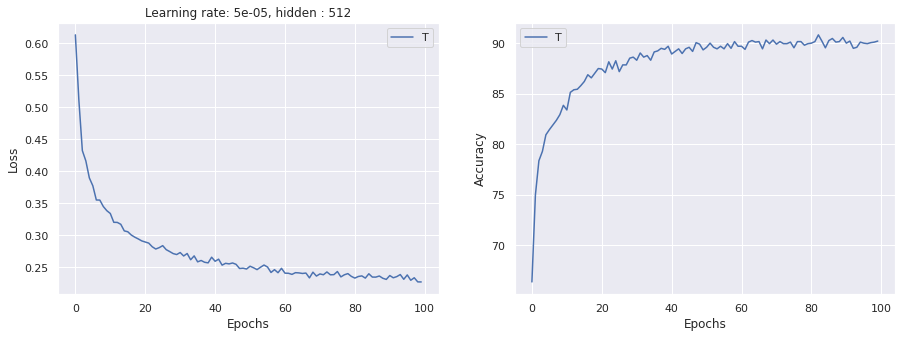

Accuracy for fold 1: 82 %
--------------------------------
FOLD 2
--------------------------------
Begin training.


  0%|          | 0/100 [00:00<?, ?it/s]

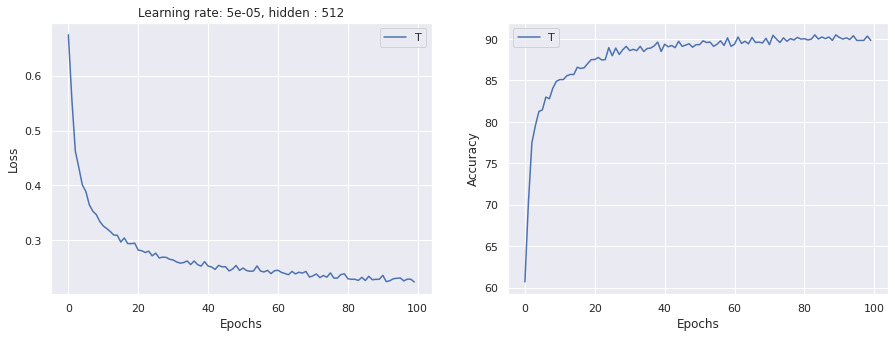

Accuracy for fold 2: 83 %
--------------------------------
FOLD 3
--------------------------------
Begin training.


  0%|          | 0/100 [00:00<?, ?it/s]

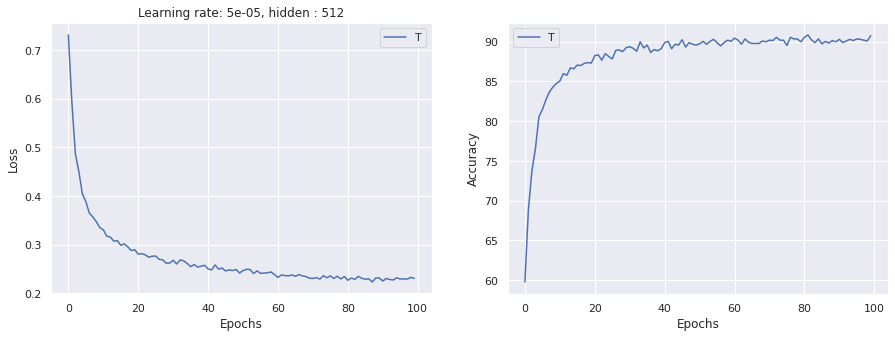

Accuracy for fold 3: 82 %
--------------------------------
FOLD 4
--------------------------------
Begin training.


  0%|          | 0/100 [00:00<?, ?it/s]

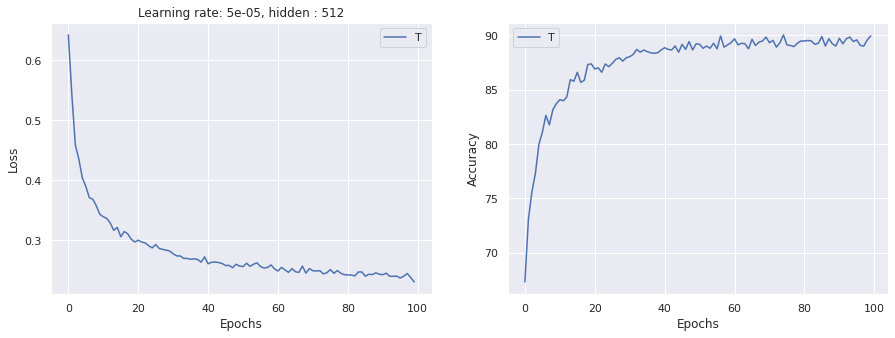

Accuracy for fold 4: 88 %
--------------------------------
FOLD 5
--------------------------------
Begin training.


  0%|          | 0/100 [00:00<?, ?it/s]

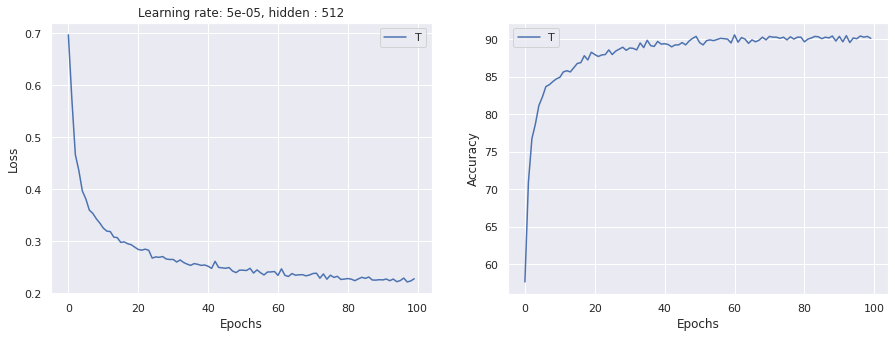

Accuracy for fold 5: 81 %
--------------------------------
FOLD 6
--------------------------------
Begin training.


  0%|          | 0/100 [00:00<?, ?it/s]

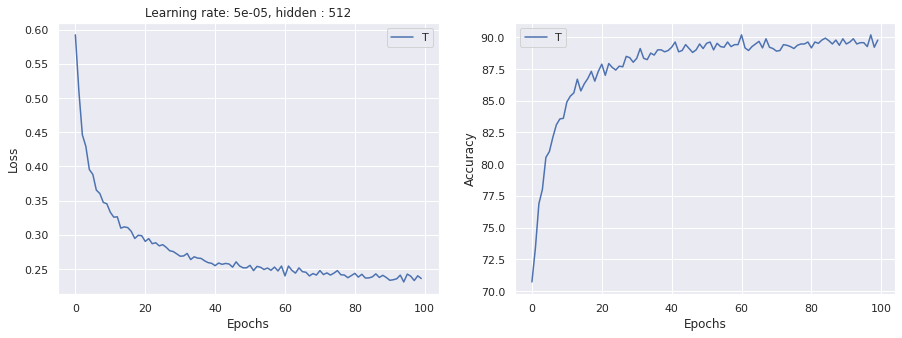

Accuracy for fold 6: 85 %
--------------------------------
FOLD 7
--------------------------------
Begin training.


  0%|          | 0/100 [00:00<?, ?it/s]

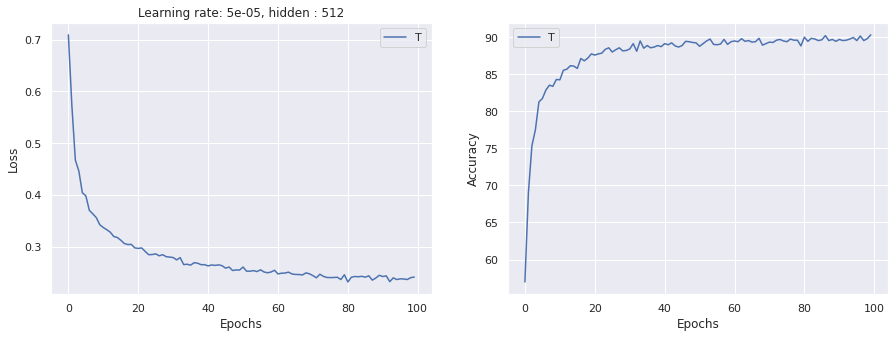

Accuracy for fold 7: 86 %
--------------------------------
FOLD 8
--------------------------------
Begin training.


  0%|          | 0/100 [00:00<?, ?it/s]

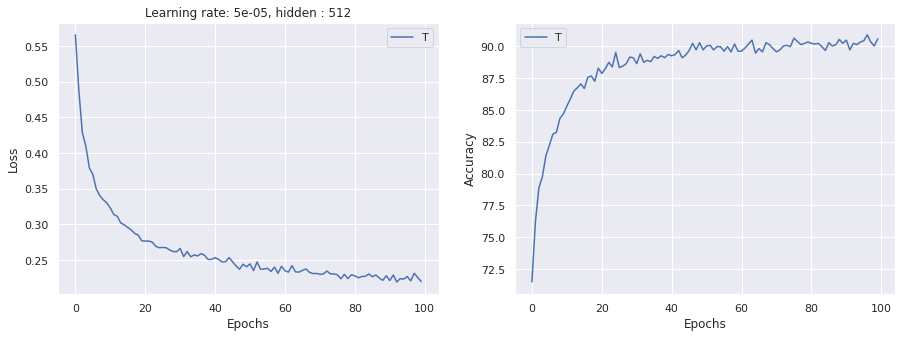

Accuracy for fold 8: 80 %
--------------------------------
FOLD 9
--------------------------------
Begin training.


  0%|          | 0/100 [00:00<?, ?it/s]

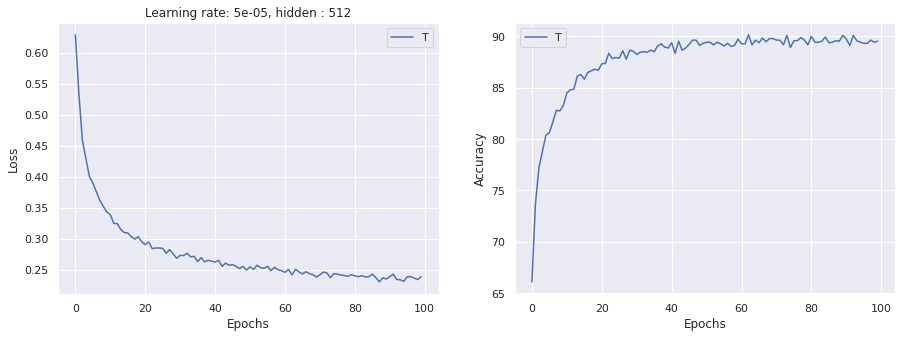

Accuracy for fold 9: 84 %
--------------------------------
K-FOLD CROSS VALIDATION RESULTS FOR 10 FOLDS
--------------------------------
Accuracy:
Fold 0: 80.0 %
Fold 1: 83.0 %
Fold 2: 83.0 %
Fold 3: 83.0 %
Fold 4: 88.0 %
Fold 5: 81.0 %
Fold 6: 86.0 %
Fold 7: 86.0 %
Fold 8: 80.0 %
Fold 9: 85.0 %
Average: 84.0 %

Sensitivity:
Fold 0:  80.33  %
Fold 1:  81.15  %
Fold 2:  84.43  %
Fold 3:  83.61  %
Fold 4:  87.7  %
Fold 5:  82.79  %
Fold 6:  84.43  %
Fold 7:  83.61  %
Fold 8:  80.99  %
Fold 9:  85.95  %
Average: 83.5 %

Specificity:
Fold 0: 78.95  %
Fold 1: 85.26  %
Fold 2: 81.91  %
Fold 3: 81.91  %
Fold 4: 89.36  %
Fold 5: 79.79  %
Fold 6: 87.23  %
Fold 7: 89.36  %
Fold 8: 78.95  %
Fold 9: 83.16  %
Average: 83.59 %
Matthews_corrcoef:
Fold 0: 0.43  %
Fold 1: 0.76  %
Fold 2: 0.41  %
Fold 3: 0.83  %
Fold 4: 0.81  %
Fold 5: 0.5  %
Fold 6: 0.82  %
Fold 7: 0.67  %
Fold 8: 0.48  %
Fold 9: 0.66  %
Average: 0.64 %


In [83]:
# Configurationh options
k_folds = 10
BATCH_SIZE = 64
#loss_function = nn.CrossEntropyLoss()
loss_function = nn.BCEWithLogitsLoss()

# For fold results
results, sensitivity, specificity, mcc = {}, {}, {}, {}

# Set fixed random number seed
torch.manual_seed(42)

# Define the K-fold Cross Validator
kfold = StratifiedKFold(n_splits=k_folds, shuffle=True)
  
# Start print
print('--------------------------------')

# K-fold Cross Validation model evaluation
for fold, (train_ids, test_ids) in enumerate(kfold.split(stacked_tensor_flat, mutations500AAfin['label'].to_numpy())):
  
  # Print
  print(f'FOLD {fold}')
  print('--------------------------------')
  
  # Sample elements randomly from a given list of ids, no replacement.
  train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
  test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
  
  # Define data loaders for training and testing data in this fold
  trainloader = torch.utils.data.DataLoader(
                    dataset, 
                    batch_size=BATCH_SIZE, sampler=train_subsampler)
  testloader = torch.utils.data.DataLoader(
                    dataset,
                    batch_size=BATCH_SIZE, sampler=test_subsampler)
  
  epochs =100
  warmup = 0.2
  learning_rate = 0.00005
  hidden= 512

  my_net = Classifier(hidden, 0.2).to(device)
  my_net.apply(init_weights)

  optimizer = optim.AdamW(my_net.parameters(), lr=learning_rate)#, weight_decay=0.001)
  total_steps = len(stacked_tensor_flat)/BATCH_SIZE
  warmup_steps = math.floor(total_steps * warmup)
  warmup_steps = math.floor(total_steps * warmup)
  scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)

  loss, acc = train_net(my_net, trainloader, loss_fn, optimizer, epochs,scheduler)


  plt.rcParams["figure.figsize"] = (15,5)
  sns.set()
  # plot train/validation loss curves
  plt.subplot(1, 2, 1)
  plt.plot(loss)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title(f'Learning rate: {learning_rate}, hidden : {hidden}')
  plt.legend(('Train'))
  #plt.title(f'Learning rate: {lr}, hidden : {h}, hidden2: {h2}')

  plt.subplot(1, 2, 2)
  plt.plot(acc)
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(('Train'))
  plt.show()

  correct, total = 0, 0
  outputs_fold, targets_fold =[], []

  my_net.eval()
  with torch.no_grad():

    # Iterate over the test data and generate predictions
    for i, data in enumerate(testloader, 0):
     
      # Get inputs
      inputs, targets, ind = data
      
      if(train_on_gpu):
        inputs, targets, ind = inputs.cuda(), targets.cuda(), ind.cuda()
      # Generate outputs
      outputs = my_net(inputs.float())
      outputs_fold.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
      targets_fold.extend(targets.cpu().detach().numpy().tolist())

      # Set total and correct
      #_, predicted = torch.max(outputs.data, 1)

      #print(torch.round(torch.sigmoid(outputs)))
      #print('Targets:', targets)
      total += targets.size(0)
      #correct += (torch.round(torch.sigmoid(outputs)) == targets).sum().item()
      outputs_round = torch.round(torch.sigmoid(outputs))
      #print('Predictions:', outputs_round)
      correct += (outputs_round.eq(targets.float().view_as(outputs_round))).sum()

    # Print accuracy
    print('Accuracy for fold %d: %d %%' % (fold, 100.0 * correct / total))
    print('--------------------------------')
    results[fold] = 100.0 * (correct / total)

    flat_list = []
    for sublist in outputs_fold:
        for item in sublist:
            flat_list.append(item)

    predictions = [1 if i>0.5 else 0 for i in flat_list]
    confusion_matrix_df = pd.DataFrame(confusion_matrix(targets_fold, predictions))
    tn, fp, fn, tp = confusion_matrix(targets_fold, predictions).ravel()

    #print(classification_report(targets_fold, predictions))
    #print(tp, tn, fp, fn )

    TPR =tp / (tp + fn)
    #print('Sensitivity: %.2f'  % (TPR*100))
    sensitivity[fold] = TPR*100

    TNR = tn / (tn + fp)
    #print('Specificity: %.2f'  % (TNR*100))
    specificity[fold] = TNR*100

    mcc[fold] =matthews_corrcoef(targets.cpu(), outputs_round.cpu())

  
# Print fold results
print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
print('--------------------------------')
print('Accuracy:')
sum = 0.0
for key, value in results.items():
  print(f'Fold {key}: {torch.round(value)} %')
  sum += value
print(f'Average: {torch.round(sum/len(results.items()))} %\n')

print('Sensitivity:')
sum = 0.0
for key, value in sensitivity.items():
  print(f'Fold {key}:  {round(value, 2)}  %')
  sum += value
print(f'Average: {round(sum/len(results.items()),2)} %\n')

print('Specificity:')
sum = 0.0
for key, value in specificity.items():
  print(f'Fold {key}: {round(value, 2)}  %')
  sum += value
print(f'Average: {round(sum/len(results.items()),2)} %')

print('Matthews_corrcoef:')
sum = 0.0
for key, value in mcc.items():
  print(f'Fold {key}: {round(value, 2)}  %')
  sum += value
print(f'Average: {round(sum/len(results.items()),2)} %')

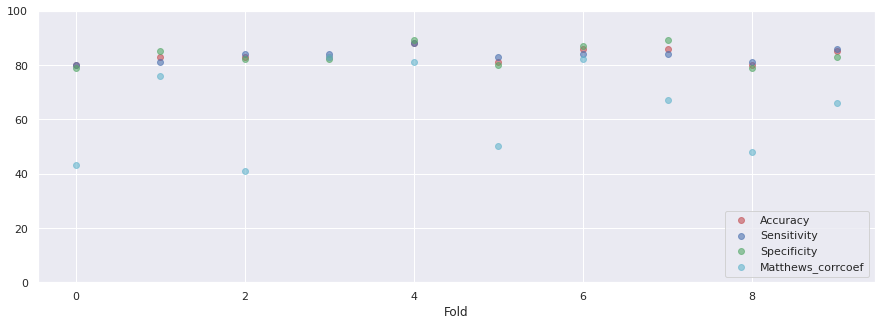

In [84]:
# line plot of k mean values with min/max error bars
folds = range(0,10)
plt.rcParams["figure.figsize"] = (15,5)
sns.set()

#plt.errorbar(folds, means, fmt='o')
# plot the ideal case in a separate color
plt.scatter(folds, [torch.round(value).cpu() for key, value in results.items()], alpha = 0.6, color='r', label = 'Accuracy')
plt.scatter(folds, [round(value) for key, value in sensitivity.items()],alpha = 0.6, color='b', label = 'Sensitivity')
plt.scatter(folds, [round(value) for key, value in specificity.items()], alpha = 0.6,color='g', label = 'Specificity')
plt.scatter(folds, [round(value*100) for key, value in mcc.items()], alpha = 0.6,color='c', label = 'Matthews_corrcoef')
plt.xlabel('Fold')
plt.ylim(0,100)
plt.legend(loc="lower right")
# show the plot
plt.show()

## Pre-Trained only + RNN

## GMM only + FCNN

Load GMM representations

In [85]:
# import difference for each mutation + labels
dif_mut = pd.read_csv('/content/drive/MyDrive/log_probWT_MUT_Tier1_2_3_CGI_humsavar500AA_filtermix3517.csv', header = None, names = ['mutation', 'log_difference', 'label'])

# exclude duplicates
dif_mut.drop_duplicates(subset = 'mutation', inplace =True)

# log_difference has been saved as string of list! Here I convert it back to list of floats
fl_dif = []
for x in dif_mut['log_difference']:
  p = x[1:-1].split(',')
  fl_dif.append([float(i) for i in p])

dif_mut['fl_dif'] = fl_dif

print('Deleterious mutations in dataset: ', len(dif_mut[dif_mut['label'] == 1]))
print('Benign mutations in dataset: ', len(dif_mut[dif_mut['label'] == 0]))

# pad to 500 AA
N= 500
fl_dif_pad =[]
for i, mut in dif_mut.iterrows():
  a = mut['fl_dif']
  new_a = a + [0] * (N - len(a))
  fl_dif_pad.append(new_a)
dif_mut['fl_dif_pad'] = fl_dif_pad


stacked_flat =[]
for i, mut in dif_mut.iterrows():
  # Rescaling (min-max normalization)
  maximum = max(mut['fl_dif_pad'])
  minimum = min(mut['fl_dif_pad'])
  fin = [x- minimum / (maximum - minimum) for x in mut['fl_dif_pad']]
  stacked_flat.append(torch.tensor(fin))
  #stacked_flat.append(torch.tensor(mut['fl_dif_pad']))

stacked_gmm = torch.stack(stacked_flat)
print(stacked_gmm.shape)

Deleterious mutations in dataset:  1218
Benign mutations in dataset:  944
torch.Size([2162, 500])


(array([1.00000e+00, 3.00000e+00, 2.00000e+00, 6.80000e+01, 1.02008e+06,
        5.76020e+04, 2.54100e+03, 5.43000e+02, 1.12000e+02, 4.80000e+01]),
 array([-1979.6354 , -1556.0131 , -1132.3906 ,  -708.7683 ,  -285.14597,
          138.47638,   562.09875,   985.72107,  1409.3434 ,  1832.9658 ,
         2256.5881 ], dtype=float32),
 <a list of 10 Patch objects>)

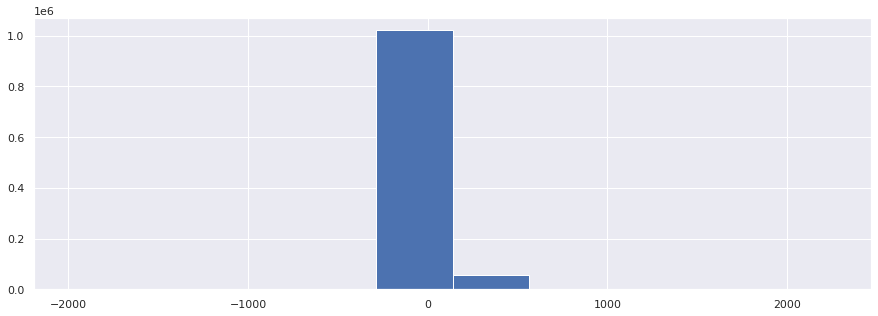

In [86]:
repre_reshape = torch.reshape(stacked_gmm,[-1])
plt.hist(repre_reshape)

(array([[228., 172.,  59., ...,   7.,   2.,   0.],
        [230., 172.,  57., ...,   7.,   2.,   0.],
        [226., 171.,  57., ...,   7.,   2.,   4.],
        ...,
        [230., 171.,  53., ...,   7.,   2.,   4.],
        [217., 164.,  69., ...,   7.,   2.,   0.],
        [228., 174.,  57., ...,   7.,   2.,   0.]]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 2162 Lists of Patches objects>)

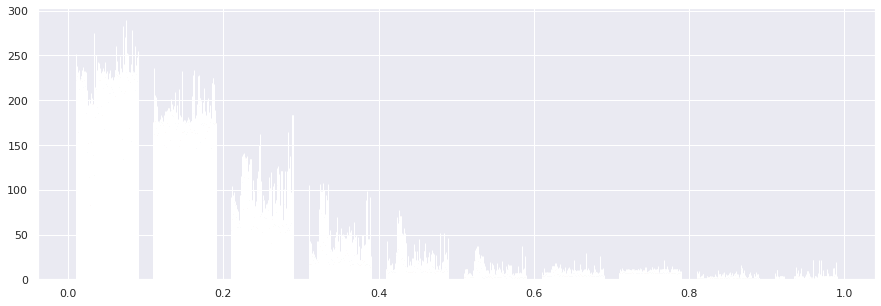

In [87]:
# Normalize
scaler = MinMaxScaler() 
stacked_gmm = scaler.fit_transform(stacked_gmm)
stacked_gmm = torch.tensor(stacked_gmm)
plt.hist(stacked_gmm)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:27.)
  if sys.path[0] == '':


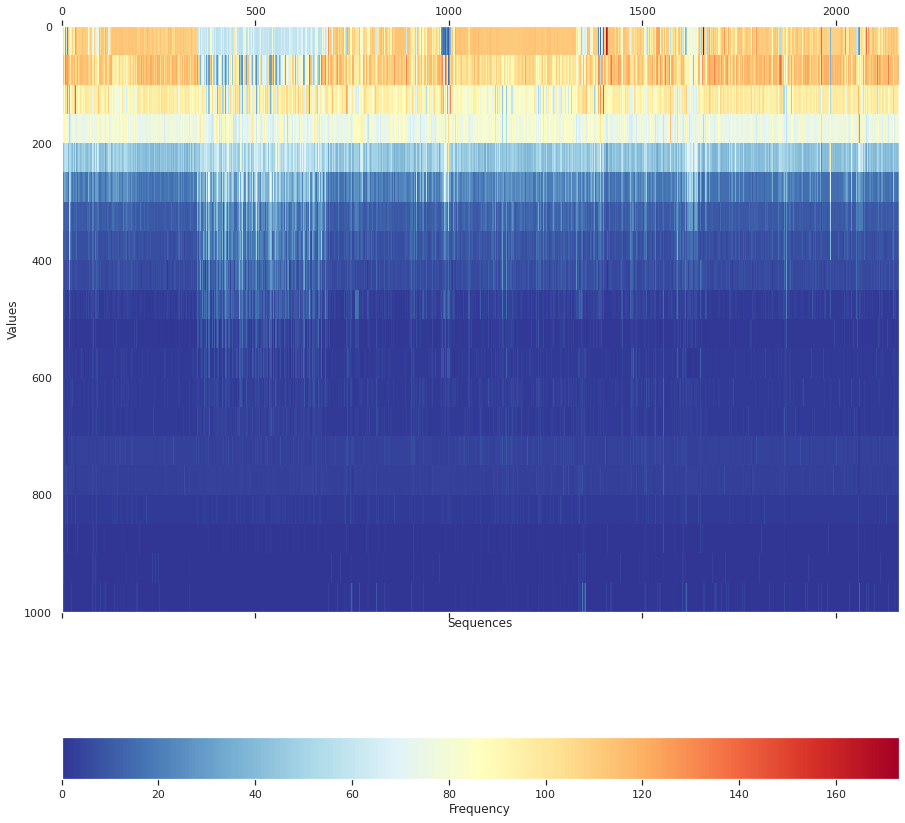

In [88]:
Nphase = 2162
Npoints = 500

phase = np.linspace(0.,1.,num=Nphase)

#calculate the bins we're going to use
minBin, maxBin = np.nanmin(stacked_gmm)*1000,np.nanmax(stacked_gmm*1000)
Nbins = 20

binedData = np.zeros((Nphase,Nbins))
for i,a in enumerate(stacked_gmm*1000):
    binedData[i,:], bins = np.histogram(a[~np.isnan(a)],bins=Nbins,range=(minBin,maxBin))

plt.figure(figsize=(15,15))
plt.matshow(binedData.T, cmap=plt.cm.RdYlBu_r, extent=(0,Nphase,maxBin,minBin), fignum=1, aspect='auto')

plt.grid(False)
c = plt.colorbar(orientation='horizontal')
plt.xlabel('Sequences')
plt.ylabel('Values')
c.set_label('Frequency')
plt.show()

In [89]:
#dataset = DWithInd(torch.from_numpy(np.array(stacked_flat)).float(), torch.from_numpy(dif_mut['label'].to_numpy()))
dataset = DWithInd(stacked_gmm, torch.from_numpy(dif_mut['label'].to_numpy()))
# run all computations on the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Running computations with %s' % torch.device(device))
if torch.cuda.is_available():
    print(torch.cuda.get_device_properties(device))

Running computations with cuda
_CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)


In [ ]:
# Configurationh options
k_folds = 10
num_epochs = 50
#loss_function = nn.CrossEntropyLoss()
loss_function = nn.BCEWithLogitsLoss()

# For fold results
results, sensitivity, specificity = {}, {}, {}

# Set fixed random number seed
torch.manual_seed(42)

# Define the K-fold Cross Validator
kfold = StratifiedKFold(n_splits=k_folds, shuffle=True)
  
# Start print
print('--------------------------------')

# K-fold Cross Validation model evaluation
for fold, (train_ids, test_ids) in enumerate(kfold.split(stacked_gmm, dif_mut['label'].to_numpy())):
  
  # Print
  print(f'FOLD {fold}')
  print('--------------------------------')
  
  # Sample elements randomly from a given list of ids, no replacement.
  train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
  test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
  
  # Define data loaders for training and testing data in this fold
  trainloader = torch.utils.data.DataLoader(
                    dataset, 
                    batch_size=64, sampler=train_subsampler)
  testloader = torch.utils.data.DataLoader(
                    dataset,
                    batch_size=64, sampler=test_subsampler)
  
  # Init the neural network
  network = Classifier(128, 0.2).to(device)
  network.apply(init_weights)
  network.train()
  
  # Initialize optimizer
  optimizer = torch.optim.Adam(network.parameters(), lr=1e-4)
  
  # Run the training loop for defined number of epochs
  for epoch in range(0, num_epochs):

    # Print epoch
    #print(f'Starting epoch {epoch+1}')

    # Set current loss value
    current_loss = 0.0

    # Iterate over the DataLoader for training data
    for i, data in enumerate(trainloader, 0):
      
      # Get inputs
      inputs, targets, ind = data
      if(train_on_gpu):
        inputs, targets, ind = inputs.cuda(), targets.cuda(), ind.cuda()
      # Zero the gradients
      optimizer.zero_grad()
      
      # Perform forward pass
      outputs = network(inputs.float())
      outputs= outputs.squeeze()
      
      # Compute loss
      loss = loss_function(outputs, targets.float())
      
      # Perform backward pass
      loss.backward()
      
      # Perform optimization
      optimizer.step()
      
      # Print statistics
      current_loss += loss.item()
      if i % 500 == 499:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 500))
          current_loss = 0.0
          
  # Process is complete.
  #print('Training process has finished. Saving trained model.')

  # Print about testing
  print('Starting testing')
  
  # Saving the model
  #save_path = f'./model-fold-{fold}.pth'
  #torch.save(network.state_dict(), save_path)

  # Evaluationfor this fold
  correct, total = 0, 0
  outputs_fold, targets_fold =[], []

  network.eval()
  with torch.no_grad():

    # Iterate over the test data and generate predictions
    for i, data in enumerate(testloader, 0):
     
      # Get inputs
      inputs, targets, ind = data
      
      if(train_on_gpu):
        inputs, targets, ind = inputs.cuda(), targets.cuda(), ind.cuda()
      # Generate outputs
      outputs = network(inputs.float())
      outputs_fold.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
      targets_fold.extend(targets.cpu().detach().numpy().tolist())

      # Set total and correct
      #_, predicted = torch.max(outputs.data, 1)

      #print(torch.round(torch.sigmoid(outputs)))
      #print('Targets:', targets)
      total += targets.size(0)
      #correct += (torch.round(torch.sigmoid(outputs)) == targets).sum().item()
      outputs_round = torch.round(torch.sigmoid(outputs))
      #print('Predictions:', outputs_round)
      correct += (outputs_round.eq(targets.float().view_as(outputs_round))).sum()

    # Print accuracy
    print('Accuracy for fold %d: %d %%' % (fold, 100.0 * correct / total))
    print('--------------------------------')
    results[fold] = 100.0 * (correct / total)

    flat_list = []
    for sublist in outputs_fold:
        for item in sublist:
            flat_list.append(item)

    predictions = [1 if i>0.5 else 0 for i in flat_list]
    confusion_matrix_df = pd.DataFrame(confusion_matrix(targets_fold, predictions))
    tn, fp, fn, tp = confusion_matrix(targets_fold, predictions).ravel()

    #print(classification_report(targets_fold, predictions))
    #print(tp, tn, fp, fn )

    TPR =tp / (tp + fn)
    #print('Sensitivity: %.2f'  % (TPR*100))
    sensitivity[fold] = TPR*100

    TNR = tn / (tn + fp)
    #print('Specificity: %.2f'  % (TNR*100))
    specificity[fold] = TNR*100

  
# Print fold results
print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
print('--------------------------------')
print('Accuracy:')
sum = 0.0
for key, value in results.items():
  print(f'Fold {key}: {torch.round(value)} %')
  sum += value
print(f'Average: {torch.round(sum/len(results.items()))} %\n')

print('Sensitivity:')
sum = 0.0
for key, value in sensitivity.items():
  print(f'Fold {key}:  {round(value, 2)}  %')
  sum += value
print(f'Average: {round(sum/len(results.items()),2)} %\n')

print('Specificity:')
sum = 0.0
for key, value in specificity.items():
  print(f'Fold {key}: {round(value, 2)}  %')
  sum += value
print(f'Average: {round(sum/len(results.items()),2)} %')


--------------------------------
FOLD 0
--------------------------------
Starting testing
Accuracy for fold 0: 70 %
--------------------------------
FOLD 1
--------------------------------
Starting testing
Accuracy for fold 1: 76 %
--------------------------------
FOLD 2
--------------------------------
Starting testing
Accuracy for fold 2: 68 %
--------------------------------
FOLD 3
--------------------------------
Starting testing
Accuracy for fold 3: 75 %
--------------------------------
FOLD 4
--------------------------------
Starting testing
Accuracy for fold 4: 71 %
--------------------------------
FOLD 5
--------------------------------
Starting testing
Accuracy for fold 5: 67 %
--------------------------------
FOLD 6
--------------------------------
Starting testing
Accuracy for fold 6: 74 %
--------------------------------
FOLD 7
--------------------------------
Starting testing
Accuracy for fold 7: 75 %
--------------------------------
FOLD 8
--------------------------------

--------------------------------
FOLD 0
--------------------------------
Begin training.


  0%|          | 0/50 [00:00<?, ?it/s]

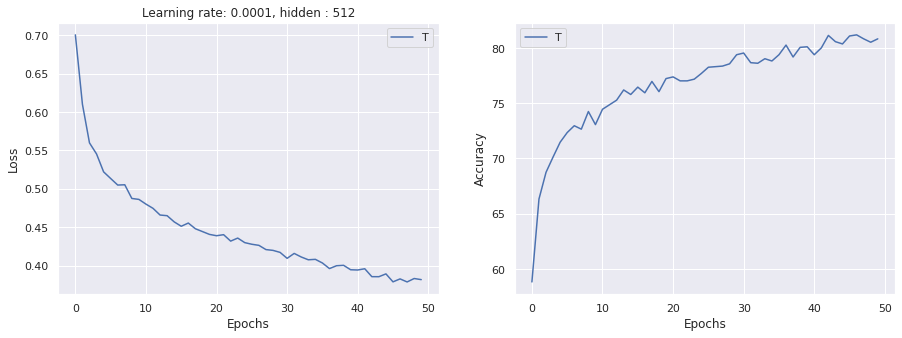

Accuracy for fold 0: 72 %
--------------------------------
FOLD 1
--------------------------------
Begin training.


  0%|          | 0/50 [00:00<?, ?it/s]

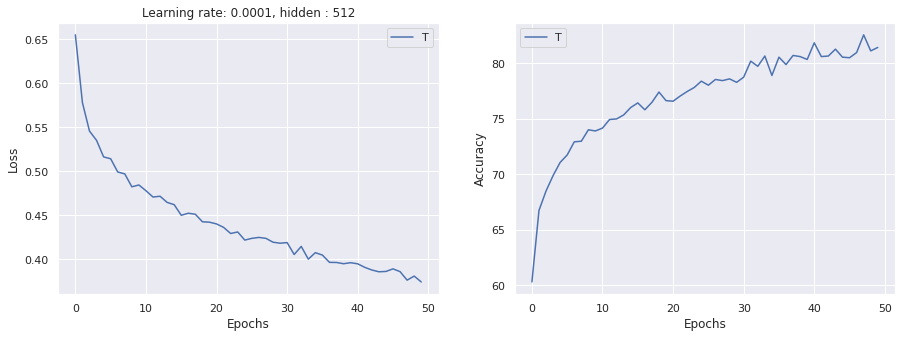

Accuracy for fold 1: 73 %
--------------------------------
FOLD 2
--------------------------------
Begin training.


  0%|          | 0/50 [00:00<?, ?it/s]

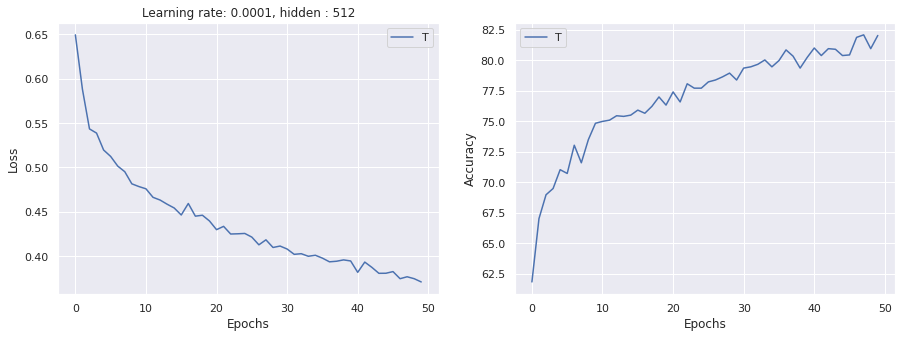

Accuracy for fold 2: 67 %
--------------------------------
FOLD 3
--------------------------------
Begin training.


  0%|          | 0/50 [00:00<?, ?it/s]

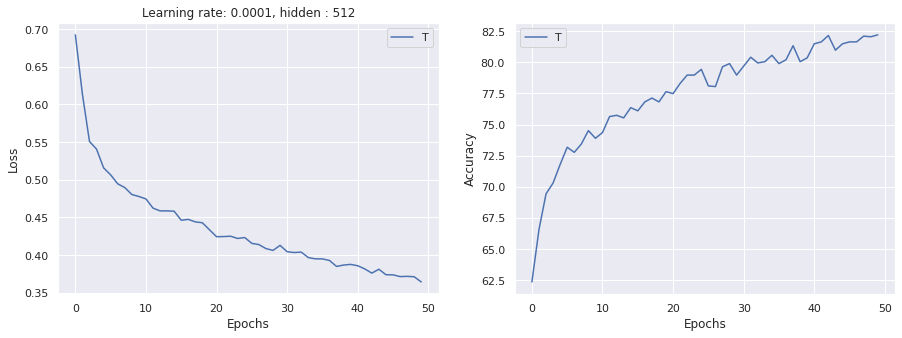

Accuracy for fold 3: 69 %
--------------------------------
FOLD 4
--------------------------------
Begin training.


  0%|          | 0/50 [00:00<?, ?it/s]

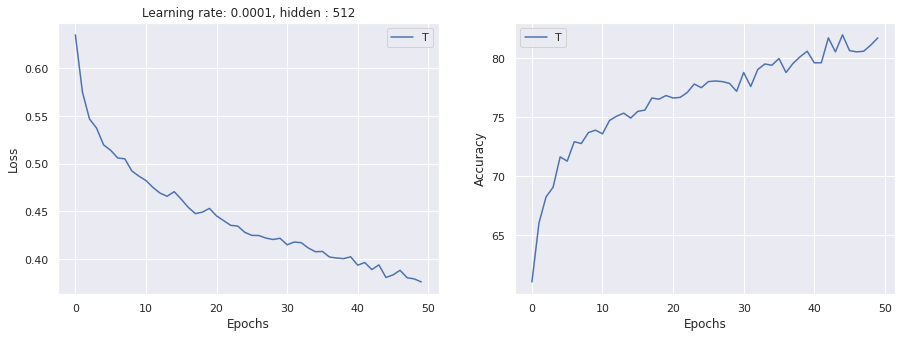

Accuracy for fold 4: 75 %
--------------------------------
FOLD 5
--------------------------------
Begin training.


  0%|          | 0/50 [00:00<?, ?it/s]

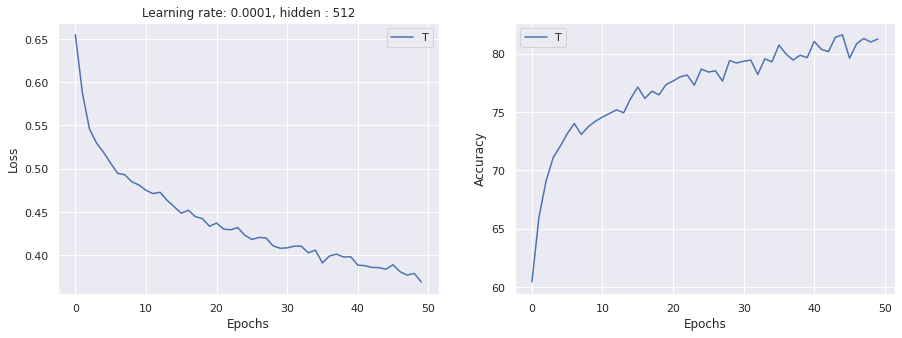

Accuracy for fold 5: 73 %
--------------------------------
FOLD 6
--------------------------------
Begin training.


  0%|          | 0/50 [00:00<?, ?it/s]

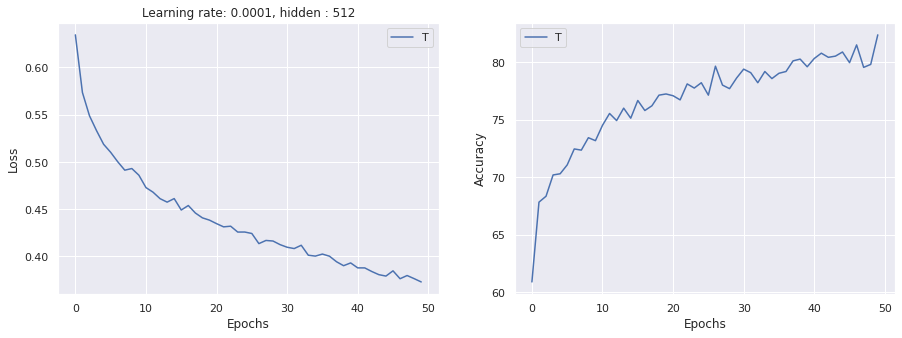

Accuracy for fold 6: 70 %
--------------------------------
FOLD 7
--------------------------------
Begin training.


  0%|          | 0/50 [00:00<?, ?it/s]

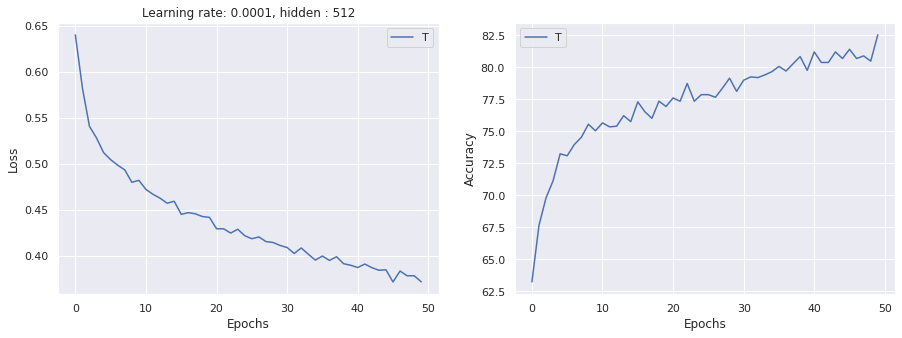

Accuracy for fold 7: 62 %
--------------------------------
FOLD 8
--------------------------------
Begin training.


  0%|          | 0/50 [00:00<?, ?it/s]

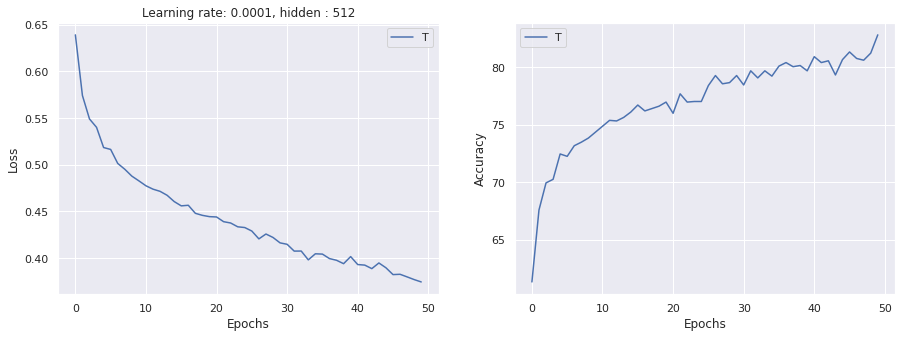

Accuracy for fold 8: 62 %
--------------------------------
FOLD 9
--------------------------------
Begin training.


  0%|          | 0/50 [00:00<?, ?it/s]

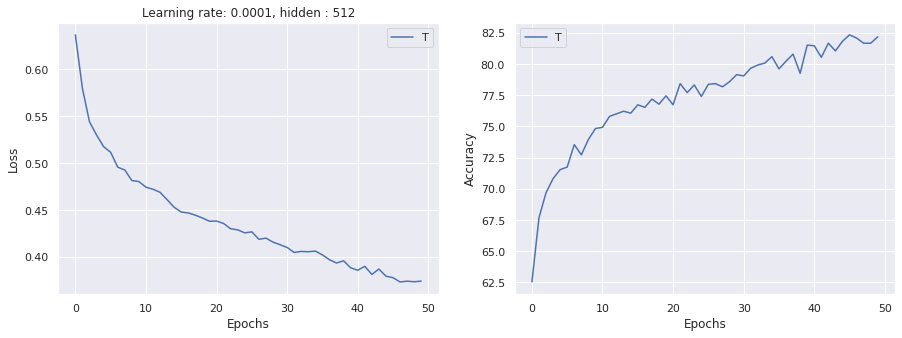

Accuracy for fold 9: 71 %
--------------------------------
K-FOLD CROSS VALIDATION RESULTS FOR 10 FOLDS
--------------------------------
Accuracy:
Fold 0: 72.0 %
Fold 1: 74.0 %
Fold 2: 68.0 %
Fold 3: 70.0 %
Fold 4: 76.0 %
Fold 5: 74.0 %
Fold 6: 71.0 %
Fold 7: 62.0 %
Fold 8: 63.0 %
Fold 9: 71.0 %
Average: 70.0 %

Sensitivity:
Fold 0:  87.7  %
Fold 1:  78.69  %
Fold 2:  93.44  %
Fold 3:  54.92  %
Fold 4:  78.69  %
Fold 5:  68.85  %
Fold 6:  81.97  %
Fold 7:  98.36  %
Fold 8:  95.87  %
Fold 9:  55.37  %
Average: 79.39 %

Specificity:
Fold 0: 52.63  %
Fold 1: 67.37  %
Fold 2: 34.04  %
Fold 3: 89.36  %
Fold 4: 72.34  %
Fold 5: 79.79  %
Fold 6: 56.38  %
Fold 7: 15.96  %
Fold 8: 21.05  %
Fold 9: 91.58  %
Average: 58.05 %
Matthews_corrcoef:
Fold 0: 0.35  %
Fold 1: 0.69  %
Fold 2: 0.35  %
Fold 3: 0.41  %
Fold 4: 0.47  %
Fold 5: 0.32  %
Fold 6: 0.19  %
Fold 7: 0.23  %
Fold 8: -0.06  %
Fold 9: 0.43  %
Average: 0.34 %


In [90]:
# Configurationh options
k_folds = 10
BATCH_SIZE = 64
#loss_function = nn.CrossEntropyLoss()
loss_function = nn.BCEWithLogitsLoss()

# For fold results
results, sensitivity, specificity, mcc = {}, {}, {}, {}

# Set fixed random number seed
torch.manual_seed(42)

# Define the K-fold Cross Validator
kfold = StratifiedKFold(n_splits=k_folds, shuffle=True)
  
# Start print
print('--------------------------------')

# K-fold Cross Validation model evaluation
for fold, (train_ids, test_ids) in enumerate(kfold.split(stacked_gmm, dif_mut['label'].to_numpy())):
  
  # Print
  print(f'FOLD {fold}')
  print('--------------------------------')
  
  # Sample elements randomly from a given list of ids, no replacement.
  train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
  test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
  
  # Define data loaders for training and testing data in this fold
  trainloader = torch.utils.data.DataLoader(
                    dataset, 
                    batch_size=BATCH_SIZE, sampler=train_subsampler)
  testloader = torch.utils.data.DataLoader(
                    dataset,
                    batch_size=BATCH_SIZE, sampler=test_subsampler)
  
  epochs =50
  warmup = 0.2
  learning_rate = 0.0001
  hidden= 512

  my_net = Classifier(hidden, 0.2).to(device)
  my_net.apply(init_weights)

  optimizer = optim.AdamW(my_net.parameters(), lr=learning_rate)#, weight_decay=0.001)
  total_steps = len(stacked_gmm)/BATCH_SIZE
  warmup_steps = math.floor(total_steps * warmup)
  warmup_steps = math.floor(total_steps * warmup)
  scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)

  loss, acc = train_net(my_net, trainloader, loss_fn, optimizer, epochs,scheduler)


  plt.rcParams["figure.figsize"] = (15,5)
  sns.set()
  # plot train/validation loss curves
  plt.subplot(1, 2, 1)
  plt.plot(loss)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title(f'Learning rate: {learning_rate}, hidden : {hidden}')
  plt.legend(('Train'))
  #plt.title(f'Learning rate: {lr}, hidden : {h}, hidden2: {h2}')

  plt.subplot(1, 2, 2)
  plt.plot(acc)
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(('Train'))
  plt.show()

  correct, total = 0, 0
  outputs_fold, targets_fold =[], []

  my_net.eval()
  with torch.no_grad():

    # Iterate over the test data and generate predictions
    for i, data in enumerate(testloader, 0):
     
      # Get inputs
      inputs, targets, ind = data
      
      if(train_on_gpu):
        inputs, targets, ind = inputs.cuda(), targets.cuda(), ind.cuda()
      # Generate outputs
      outputs = my_net(inputs.float())
      outputs_fold.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
      targets_fold.extend(targets.cpu().detach().numpy().tolist())

      # Set total and correct
      #_, predicted = torch.max(outputs.data, 1)

      #print(torch.round(torch.sigmoid(outputs)))
      #print('Targets:', targets)
      total += targets.size(0)
      #correct += (torch.round(torch.sigmoid(outputs)) == targets).sum().item()
      outputs_round = torch.round(torch.sigmoid(outputs))
      #print('Predictions:', outputs_round)
      correct += (outputs_round.eq(targets.float().view_as(outputs_round))).sum()

    # Print accuracy
    print('Accuracy for fold %d: %d %%' % (fold, 100.0 * correct / total))
    print('--------------------------------')
    results[fold] = 100.0 * (correct / total)

    flat_list = []
    for sublist in outputs_fold:
        for item in sublist:
            flat_list.append(item)

    predictions = [1 if i>0.5 else 0 for i in flat_list]
    confusion_matrix_df = pd.DataFrame(confusion_matrix(targets_fold, predictions))
    tn, fp, fn, tp = confusion_matrix(targets_fold, predictions).ravel()

    #print(classification_report(targets_fold, predictions))
    #print(tp, tn, fp, fn )

    TPR =tp / (tp + fn)
    #print('Sensitivity: %.2f'  % (TPR*100))
    sensitivity[fold] = TPR*100

    TNR = tn / (tn + fp)
    #print('Specificity: %.2f'  % (TNR*100))
    specificity[fold] = TNR*100

    mcc[fold] =matthews_corrcoef(targets.cpu(), outputs_round.cpu())

  
# Print fold results
print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
print('--------------------------------')
print('Accuracy:')
sum = 0.0
for key, value in results.items():
  print(f'Fold {key}: {torch.round(value)} %')
  sum += value
print(f'Average: {torch.round(sum/len(results.items()))} %\n')

print('Sensitivity:')
sum = 0.0
for key, value in sensitivity.items():
  print(f'Fold {key}:  {round(value, 2)}  %')
  sum += value
print(f'Average: {round(sum/len(results.items()),2)} %\n')

print('Specificity:')
sum = 0.0
for key, value in specificity.items():
  print(f'Fold {key}: {round(value, 2)}  %')
  sum += value
print(f'Average: {round(sum/len(results.items()),2)} %')

print('Matthews_corrcoef:')
sum = 0.0
for key, value in mcc.items():
  print(f'Fold {key}: {round(value, 2)}  %')
  sum += value
print(f'Average: {round(sum/len(results.items()),2)} %')

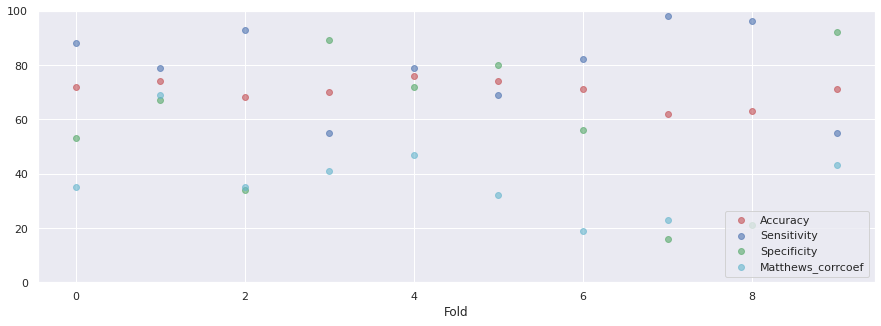

In [91]:
# line plot of k mean values with min/max error bars
folds = range(0,10)
plt.rcParams["figure.figsize"] = (15,5)
sns.set()

#plt.errorbar(folds, means, fmt='o')
# plot the ideal case in a separate color
plt.scatter(folds, [torch.round(value).cpu() for key, value in results.items()], alpha = 0.6, color='r', label = 'Accuracy')
plt.scatter(folds, [round(value) for key, value in sensitivity.items()],alpha = 0.6, color='b', label = 'Sensitivity')
plt.scatter(folds, [round(value) for key, value in specificity.items()], alpha = 0.6,color='g', label = 'Specificity')
plt.scatter(folds, [round(value*100) for key, value in mcc.items()], alpha = 0.6,color='c', label = 'Matthews_corrcoef')
plt.xlabel('Fold')
plt.ylim(0,100)
plt.legend(loc="lower right")
# show the plot
plt.show()

## GMM only + RNN

In [ ]:
num_sequ = len(stacked_flat)
seq_length = 500
input_size =1
features = np.array((stacked_flat))
#y = np.array((y))

features = features.reshape(num_sequ, seq_length, input_size)
print("Transform input dimensions:\
      For a batch size B and sequence of length S, the input has shape [B,S,A]", features.shape)

dataset2 = DWithInd(torch.from_numpy(features).float(), torch.from_numpy(dif_mut['label'].to_numpy()))
# run all computations on the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Running computations with %s' % torch.device(device))
if torch.cuda.is_available():
    print(torch.cuda.get_device_properties(device))

Transform input dimensions:      For a batch size B and sequence of length S, the input has shape [B,S,A] (2162, 500, 1)
Running computations with cuda
_CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


In [ ]:
lr_list= [0.00005]
hidden_list = [32]

# Set fixed random number seed
torch.manual_seed(42)
results = {}
sens = {}
spec = {}
mcc_value = {}

# Instantiate the model w/ hyperparams
output_size = 1
embedding_dim = 1
num_epochs = 100
n_layers = 1
clip = 5
batch_size=34
# Configuration options
k_folds = 10

# Define K-fold Cross Validator
kfold = KFold(n_splits=5, shuffle=True)
# Start print
print('--------------------------------')

# K-fold Cross Validation model evaluation

for fold, (train_ids, test_ids) in enumerate(kfold.split(stacked_flat, dif_mut['label'].to_numpy())):
   
    # Print
    print(f'FOLD {fold}')
    print('--------------------------------')

    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    val_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
    
    trainloader = torch.utils.data.DataLoader(
                      dataset2, 
                      batch_size=34, sampler=train_subsampler, drop_last =True)
    testloader = torch.utils.data.DataLoader(
                      dataset2,
                      batch_size=34, sampler=test_subsampler, drop_last =True)



    for learning_rate in lr_list:
        for hidden_dim in hidden_list:
            
            criterion = nn.BCELoss()
            net = toyRNN(output_size, hidden_dim, n_layers)
            net.apply(init_weights)
            if(train_on_gpu):
              net.cuda()

            optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
            net.train()

            train_loss = np.zeros((num_epochs))
            val_loss = np.zeros((num_epochs))
            train_acc = np.zeros((num_epochs))
            val_acc = np.zeros((num_epochs))

            for epoch in range(0, num_epochs):

              total_samples = 0 # count samples of epoch
              total_samples_val = 0
              running_loss = 0.0
              running_acc =0.0
              running_loss_val =0.0
              running_acc_val =0.0

              h = net.init_hidden(batch_size)
              for i, data in enumerate(trainloader):

                #h = tuple([each.data for each in h])# Put when LSTM, take out when GRU
                
                # Get inputs
                inputs, targets, ind = data
                if(train_on_gpu):
                  inputs, targets, ind = inputs.cuda(), targets.cuda(), ind.cuda()
                # Zero the gradients
                optimizer.zero_grad()       
                # Perform forward pass
                outputs, h = net(inputs, h) 
                h= h.data      
                # Compute loss
                loss = criterion(outputs, targets.float())    
                # Perform backward pass
                loss.backward()   
                nn.utils.clip_grad_norm_(net.parameters(), clip)

                # Perform optimization
                optimizer.step()      
                # Print statistics
                total_samples += targets.size(0)
                running_loss += loss.item()
                
                outputs_round = torch.round(outputs.squeeze())
                running_acc += (outputs_round.eq(targets.float().view_as(outputs_round))).sum()


              train_loss[epoch] = running_loss / (i + 1)
              train_acc[epoch] = running_acc / total_samples     

              # Evaluation
              with torch.no_grad():

                val_h = net.init_hidden(batch_size)
                # Iterate over the test data and generate predictions
                net.eval()
                for j, data in enumerate(testloader, 0):
                  
                    #val_h = tuple([each.data for each in val_h])  # Put when LSTM, take out when GRU

                    # Get inputs
                    inputs, targets, ind = data
                    if(train_on_gpu):
                      inputs, targets = inputs.cuda(), targets.cuda()
                    # Generate outputs
                    outputs, val_h = net(inputs, val_h)
                    val_h = val_h.data
                    total_samples_val += targets.size(0)
                    # Compute loss
                    loss = criterion(outputs, targets.float())
                    running_loss_val += loss.item()
                    outputs_round = torch.round(outputs.squeeze())
                    running_acc_val += (outputs_round.eq(targets.float().view_as(outputs_round))).sum()
            
              val_loss[epoch] = running_loss_val / (j + 1)
              val_acc[epoch] = running_acc_val / total_samples_val     

              net.train() # reset to train mode after iterationg through validation data


            plt.rcParams["figure.figsize"] = (15,5)
            # plot train/test loss curves
            plt.subplot(1, 2, 1)
            plt.plot(train_loss)
            plt.plot(val_loss)
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend(('Train', 'Validation'))


            # plot train/test balanced accuracy
            plt.subplot(1, 2, 2)
            plt.plot(train_acc)
            plt.plot(val_acc)
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.legend(('Train', 'Validation'))
            plt.title(f'lr: {learning_rate} and hidden dim: {hidden_dim}')
            plt.show()



    # Print accuracy
    print('Accuracy for fold %d: %d %%' % (fold, 100.0 * running_acc_val / total_samples_val))
    print('--------------------------------')
    results[fold] = 100.0 * (running_acc_val / total_samples_val)

# Print fold results
print(f'K-FOLD CROSS VALIDATION ACCURACY FOR {k_folds} FOLDS')
print('--------------------------------')
sum = 0.0
for key, value in results.items():
  print(f'Fold {key}: {value} %')
  sum += value
print(f'Average: {sum/len(results.items())} %')


--------------------------------
FOLD 0
--------------------------------


KeyboardInterrupt: ignored

In [ ]:
# Instantiate the model w/ hyperparams
output_size = 1
embedding_dim = 1
hidden_dim = 32
n_layers = 1
clip = 5
batch_size=34
# Configuration options
k_folds = 10
# For fold results
results = {}
sens = {}
spec = {}
mcc_value = {}

# Set fixed random number seed
torch.manual_seed(42)


# Define K-fold Cross Validator
kfold = StratifiedKFold(n_splits=k_folds, shuffle=True)
# Start print
print('--------------------------------')

# K-fold Cross Validation model evaluation

for fold, (train_ids, test_ids) in enumerate(kfold.split(stacked_flat, dif_mut['label'].to_numpy())):
   
    # Print
    print(f'FOLD {fold}')
    print('--------------------------------')

    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
    
    # Define data loaders for training and testing data in this fold
    trainloader = torch.utils.data.DataLoader(
                      dataset2, 
                      batch_size=34, sampler=train_subsampler, drop_last =True)
    testloader = torch.utils.data.DataLoader(
                      dataset2,
                      batch_size=34, sampler=test_subsampler, drop_last =True)


    net = LSTM(output_size, hidden_dim, n_layers)
    net.apply(init_weights)
    # move model to GPU, if available
    if(train_on_gpu):
      net.cuda()

    #print(net)

    # loss and optimization functions
    lr=0.00005

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)

    #training params

    num_epochs = 50 # 3-4 is approx where I noticed the validation loss stop decreasing
    indices_train = [] #initialise train indices used for distributions for each fold
    indices_test = [] #initialise test indices used for distributions for each fold

    # Run the training loop for defined number of epochs
    for epoch in range(0, num_epochs):

      # Print epoch
      print(f'Starting epoch {epoch+1}')
      h = net.init_hidden(batch_size)

      # Set current loss value
      current_loss = 0.0

      # Iterate over the DataLoader for training data
      for i, data in enumerate(trainloader, 0):
        
        h = tuple([each.data for each in h])

        # Get inputs
        inputs, targets, ind = data
        if(train_on_gpu):
          inputs, targets, ind = inputs.cuda(), targets.cuda(), ind.cuda()
        if epoch == 0: # calculate indices for one epoch as the same for the following epochs
          temp = list(ind.detach().cpu().numpy())
          indices_train = indices_train + temp # append the indices of the batch
        #print(inputs.shape)
        
        # Zero the gradients
        optimizer.zero_grad()       
        # Perform forward pass
        outputs, h = net(inputs, h)       
        # Compute loss
        loss = criterion(outputs, targets.float())      
        # Perform backward pass
        loss.backward()        
        nn.utils.clip_grad_norm_(net.parameters(), clip)

        # Perform optimization
        optimizer.step()      
        # Print statistics
        current_loss += loss.item()
     
      print('Loss is', current_loss)

    indices_train = np.array((indices_train))
    
    '''
    # Distribution of proteins in train test
    #print(indices_train)      
    unique, counts = np.unique(protein[indices_train], return_counts=True)
    dict_data1 = dict(zip(unique, counts))
    
    with open(f"{fold}_train.csv", 'w') as csv_file:  
        writer = csv.writer(csv_file)
        for key, value in dict_data1.items():
          writer.writerow([key, value])

    # Distribution of passenger / drivers in train
    labels = ['passengers' , 'drivers']
    values = [sum(y_num[indices_train]), len(indices_train) - sum(y_num[indices_train])]
    plt.bar(labels, values, color ='maroon', width = 0.4)
    plt.ylabel("# of sequences")
    plt.title(f"Class distribution of training set for {fold} fold")
    plt.show()
    '''    
    # Process is complete.
    print('Training process has finished. Saving trained model.')

    # Print about testing
    print('Starting testing')
    
    # Saving the model
    #save_path = f'./model-fold-{fold}.pth'
    #torch.save(net.state_dict(), save_path)

    # Evaluation for this fold
    correct, total = 0, 0
    outputs_fold, targets_fold =[], []
    net.eval()
    with torch.no_grad():
      TN = 0
      TP = 0
      FN = 0
      FP = 0
      # Outputs for entire testloader
      y_out = np.zeros((math.floor(len(test_ids) / batch_size), batch_size))

      val_h = net.init_hidden(batch_size)
      # Iterate over the test data and generate predictions
      for i, data in enumerate(testloader, 0):
        
        val_h = tuple([each.data for each in val_h])

        '''# Get inputs
        inputs, targets, ind = data
        
        if(train_on_gpu):
          inputs, targets, ind= inputs.cuda(), targets.cuda(), ind.cuda()

        temp = list(ind.detach().cpu().numpy())
        indices_test = indices_test + temp # append the indices of the batch
        
        # Generate outputs
        outputs, val_h = net(inputs, val_h)
        TN, TP, FN, FP = scores(TN, TP, FN, FP, targets, outputs)
        print('TN, TP, FN, FP:', TN, TP, FN, FP)
        y_out[i, :] = outputs.detach().cpu().numpy()
        total += targets.size(0)
        outputs_round = torch.round(outputs.squeeze())
        correct += (outputs_round.eq(targets.float().view_as(outputs_round))).sum()
        '''
        # Get inputs
        inputs, targets, ind = data
        
        if(train_on_gpu):
          inputs, targets, ind = inputs.cuda(), targets.cuda(), ind.cuda()
        # Generate outputs
        outputs, val_h = net(inputs, val_h)       
        outputs_fold.extend(outputs.cpu().detach().numpy().tolist())
        targets_fold.extend(targets.cpu().detach().numpy().tolist())

        # Set total and correct
        #_, predicted = torch.max(outputs.data, 1)

        #print(torch.round(torch.sigmoid(outputs)))
        #print(targets)
        total += targets.size(0)
        #correct += (torch.round(torch.sigmoid(outputs)) == targets).sum().item()
        outputs_round = torch.round(outputs)
        correct += (outputs_round.eq(targets.float().view_as(outputs_round))).sum()

      # Print accuracy
      print('Accuracy for fold %d: %d %%' % (fold, 100.0 * correct / total))
      print('--------------------------------')
      results[fold] = 100.0 * (correct / total)

      flat_list = []
      for sublist in outputs_fold:
          #for item in sublist:
          flat_list.append(item)


      predictions = [1 if i>0.5 else 0 for i in flat_list]
      confusion_matrix_df = pd.DataFrame(confusion_matrix(targets_fold, predictions))
      tn, fp, fn, tp = confusion_matrix(targets_fold, predictions).ravel()

      #print(classification_report(targets_fold, predictions))
      #print(tp, tn, fp, fn )

      TPR =tp / (tp + fn)
      #print('Sensitivity: %.2f'  % (TPR*100))
      sensitivity[fold] = TPR*100

      TNR = tn / (tn + fp)
      #print('Specificity: %.2f'  % (TNR*100))
      specificity[fold] = TNR*100

      '''  
      # Distribution of proteins in test
      indices_test = np.array((indices_test)) 
     
      unique, counts = np.unique(protein[indices_test], return_counts=True)
      dict_data1 = dict(zip(unique, counts))
      
      with open(f"{fold}_test.csv", 'w') as csv_file:  
          writer = csv.writer(csv_file)
          for key, value in dict_data1.items():
            writer.writerow([key, value])

      # Distribution of passenger / drivers in test set
      labels = ['passengers' , 'drivers']
      values = [sum(y_num[indices_test]), len(indices_test) - sum(y_num[indices_test])]
      plt.bar(labels, values, color ='maroon', width = 0.4)
      plt.ylabel("# of sequences")
      plt.title(f"Class distribution of test set for {fold} fold")
      plt.show()


      leng = len(y_out.flatten()) # omit the outputs not produced due to batching ( last batch not complete is not computed)
      print('leng', leng)
      print('Length of indices_test', len(indices_test))
      # calculate scores
      auc = roc_auc_score(y_data[indices_test], y_out.flatten())
      #lr_auc = roc_auc_score(testy, lr_probs)
      # summarize scores
      print('ROC score =%.3f' % (auc))
      # calculate roc curves
      fpr, tpr, _ = roc_curve(y_data[indices_test], y_out.flatten())
      # plot the roc curve for the model
      plt.plot(fpr, tpr, marker='.', label=f'Fold {fold}')
      # axis labels
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      # show the legend
      plt.legend()
      # show the plot
      plt.show()
      '''
    
# Print fold results
print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
print('--------------------------------')
print('Accuracy:')
sum = 0.0
for key, value in results.items():
  print(f'Fold {key}: {torch.round(value)} %')
  sum += value
print(f'Average: {torch.round(sum/len(results.items()))} %\n')

print('Sensitivity:')
sum = 0.0
for key, value in sensitivity.items():
  print(f'Fold {key}:  {round(value, 2)}  %')
  sum += value
print(f'Average: {round(sum/len(results.items()),2)} %\n')

print('Specificity:')
sum = 0.0
for key, value in specificity.items():
  print(f'Fold {key}: {round(value, 2)}  %')
  sum += value
print(f'Average: {round(sum/len(results.items()),2)} %')

--------------------------------
FOLD 0
--------------------------------
Starting epoch 1
Loss is 39.94457656145096
Starting epoch 2
Loss is 40.759886026382446
Starting epoch 3
Loss is 39.83088707923889
Starting epoch 4
Loss is 40.00480681657791
Starting epoch 5
Loss is 39.659911811351776
Starting epoch 6
Loss is 39.88152188062668
Starting epoch 7
Loss is 39.882518112659454
Starting epoch 8
Loss is 39.56587356328964
Starting epoch 9
Loss is 39.60917067527771
Starting epoch 10
Loss is 39.604854583740234
Starting epoch 11
Loss is 39.86859691143036
Starting epoch 12
Loss is 39.74035435914993
Starting epoch 13
Loss is 39.32686132192612
Starting epoch 14
Loss is 39.44922488927841
Starting epoch 15
Loss is 39.76420593261719
Starting epoch 16
Loss is 39.66929167509079
Starting epoch 17
Loss is 39.7977648973465
Starting epoch 18
Loss is 39.381700217723846
Starting epoch 19
Loss is 39.3154137134552
Starting epoch 20
Loss is 39.63385236263275
Starting epoch 21
Loss is 39.4517867565155
Starting e

KeyboardInterrupt: ignored

## Pre-Trained + GMM + FCNN

In [92]:
seq_all_nocrop = []

for k in [x for x in range(1, 3)]:# if x != 11]:
  with open(f'/content/drive/MyDrive/my_colab/3rdYear/GMM/prott5_Tier1_2_3_humsavar_500AA_{k}.pickle','rb') as file_handle:
    file_temp = pickle.load(file_handle) # load the sequences of one batch (2000)

    seq_temp = []
    for seq in file_temp:
      AA_seq_temp = []
      for AA in seq:
        AA_seq_temp.append(torch.mean(AA))
      seq_temp.append(AA_seq_temp)
    seq_all_nocrop = seq_all_nocrop + seq_temp

# pad to 500AA
seq_all_cropped = []
for seq_single in seq_all_nocrop:
  seq_single = torch.tensor(seq_single)
  to_pad = 500 - len(seq_single) 
  seq_all_cropped.append(F.pad(input=seq_single, pad=(0, to_pad), mode='constant', value=0))

gc.collect()
seq_cropped_flat = []
for i in seq_all_cropped:

 ## Rescaling (min-max normalization)
  #maximum = max(i)
  #minimum = min(i)
  #fin = [x- minimum / (maximum - minimum) for x in i]
  #seq_cropped_flat.append(torch.tensor(fin))
  seq_cropped_flat.append(torch.flatten(i))

stacked_tensor_flat = torch.stack(seq_cropped_flat)
print(stacked_tensor_flat.shape)

torch.Size([2162, 500])


(array([[ 7.,  2., 10., ..., 28.,  4.,  0.],
        [ 7.,  6., 18., ..., 39., 15.,  5.],
        [ 7.,  6., 18., ..., 40., 14.,  5.],
        ...,
        [ 7.,  8., 30., ..., 34., 18., 12.],
        [ 5.,  4., 12., ..., 29., 12.,  4.],
        [ 6.,  2.,  7., ...,  8.,  1.,  0.]]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 2162 Lists of Patches objects>)

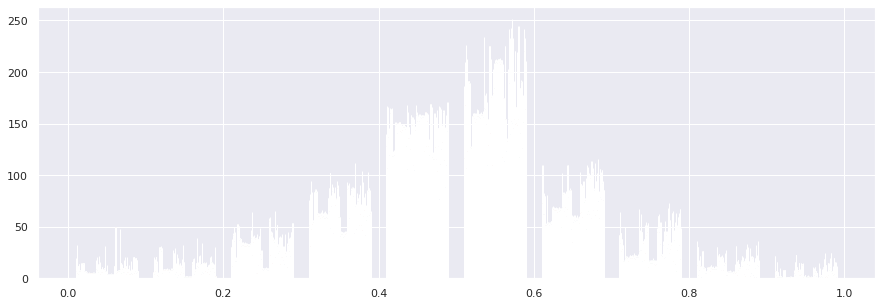

In [101]:
# Normalize
scaler = MinMaxScaler() 
stacked_tensor_flat = scaler.fit_transform(stacked_tensor_flat)
stacked_tensor_flat = torch.tensor(stacked_tensor_flat)
plt.hist(stacked_tensor_flat)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:27.)
  if sys.path[0] == '':


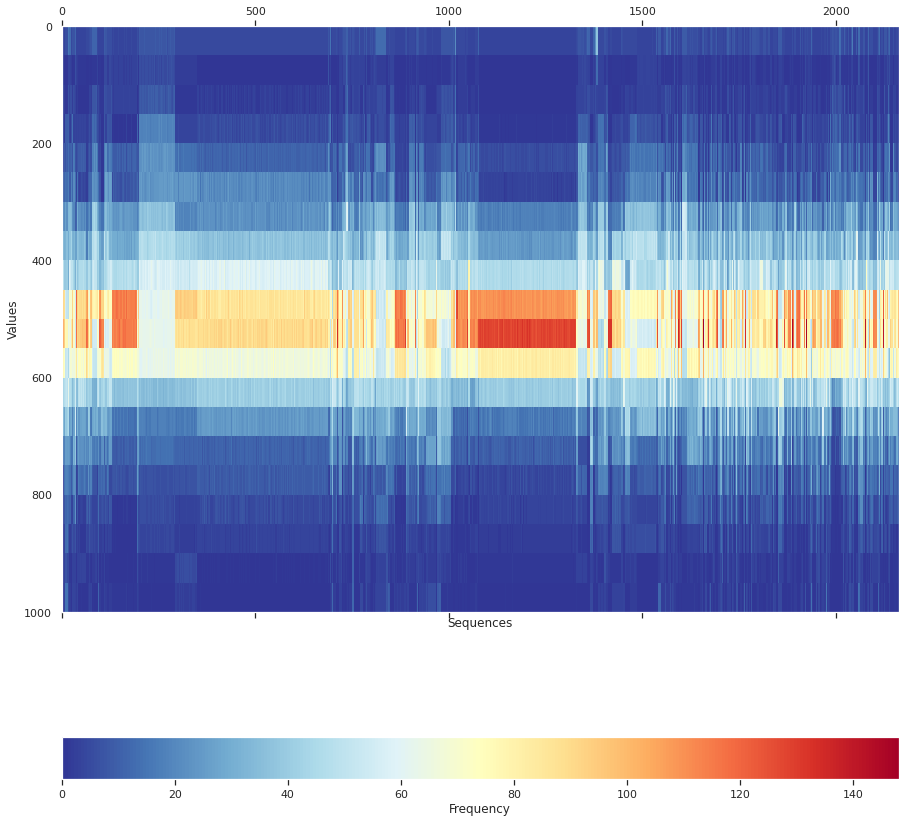

In [102]:
Nphase = 2162
Npoints = 500

phase = np.linspace(0.,1.,num=Nphase)

#calculate the bins we're going to use
minBin, maxBin = np.nanmin(stacked_tensor_flat)*1000,np.nanmax(stacked_tensor_flat*1000)
Nbins = 20

binedData = np.zeros((Nphase,Nbins))
for i,a in enumerate(stacked_tensor_flat*1000):
    binedData[i,:], bins = np.histogram(a[~np.isnan(a)],bins=Nbins,range=(minBin,maxBin))

plt.figure(figsize=(15,15))
plt.matshow(binedData.T, cmap=plt.cm.RdYlBu_r, extent=(0,Nphase,maxBin,minBin), fignum=1, aspect='auto')

plt.grid(False)
c = plt.colorbar(orientation='horizontal')
plt.xlabel('Sequences')
plt.ylabel('Values')
c.set_label('Frequency')
plt.show()

In [93]:
# import difference for each mutation + labels
dif_mut = pd.read_csv('/content/drive/MyDrive/log_probWT_MUT_Tier1_2_3_CGI_humsavar500AA_filtermix3517.csv', header = None, names = ['mutation', 'log_difference', 'label'])

# exclude duplicates
dif_mut.drop_duplicates(subset = 'mutation', inplace =True)

# log_difference has been saved as string of list! Here I convert it back to list of floats
fl_dif = []
for x in dif_mut['log_difference']:
  p = x[1:-1].split(',')
  fl_dif.append([float(i) for i in p])

dif_mut['fl_dif'] = fl_dif

print('Deleterious mutations in dataset: ',len(dif_mut[dif_mut['label'] == 1]))
print('Benign mutations in dataset: ',len(dif_mut[dif_mut['label'] == 0]))

# pad to 500 AA
N= 500
fl_dif_pad =[]
for i, mut in dif_mut.iterrows():
  a = mut['fl_dif']
  new_a = a + [0] * (N - len(a))
  fl_dif_pad.append(new_a)
dif_mut['fl_dif_pad'] = fl_dif_pad

#shuf_dif_mut = dif_mut.sample(frac=1) # shuffle
stacked_flat =[]
for i, mut in dif_mut.iterrows():

  # Rescaling (min-max normalization)
  maximum = max(mut['fl_dif_pad'])
  minimum = min(mut['fl_dif_pad'])
  fin = [x- minimum / (maximum - minimum) for x in mut['fl_dif_pad']]
  stacked_flat.append(torch.tensor(fin))
  #stacked_flat.append(torch.tensor(mut['fl_dif_pad']))

Deleterious mutations in dataset:  1218
Benign mutations in dataset:  944


In [94]:
stacked_tensor_flat2 = torch.stack(stacked_flat)
print(stacked_tensor_flat2.shape)

torch.Size([2162, 500])


(array([[228., 172.,  59., ...,   7.,   2.,   0.],
        [230., 172.,  57., ...,   7.,   2.,   0.],
        [226., 171.,  57., ...,   7.,   2.,   4.],
        ...,
        [230., 171.,  53., ...,   7.,   2.,   4.],
        [217., 164.,  69., ...,   7.,   2.,   0.],
        [228., 174.,  57., ...,   7.,   2.,   0.]]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 2162 Lists of Patches objects>)

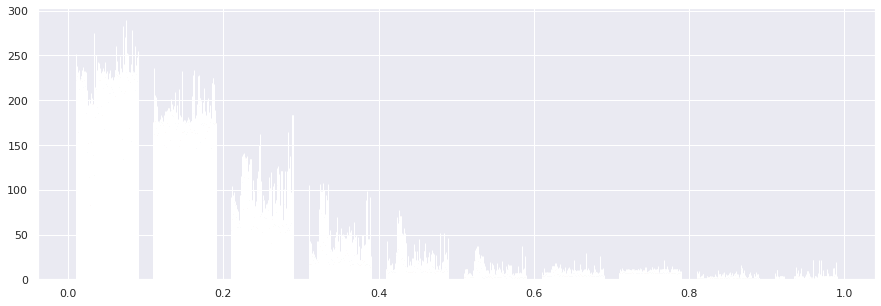

In [103]:
# Normalize
scaler = MinMaxScaler() 
stacked_tensor_flat2 = scaler.fit_transform(stacked_tensor_flat2)
stacked_tensor_flat2 = torch.tensor(stacked_tensor_flat2)
plt.hist(stacked_tensor_flat2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:27.)
  if sys.path[0] == '':


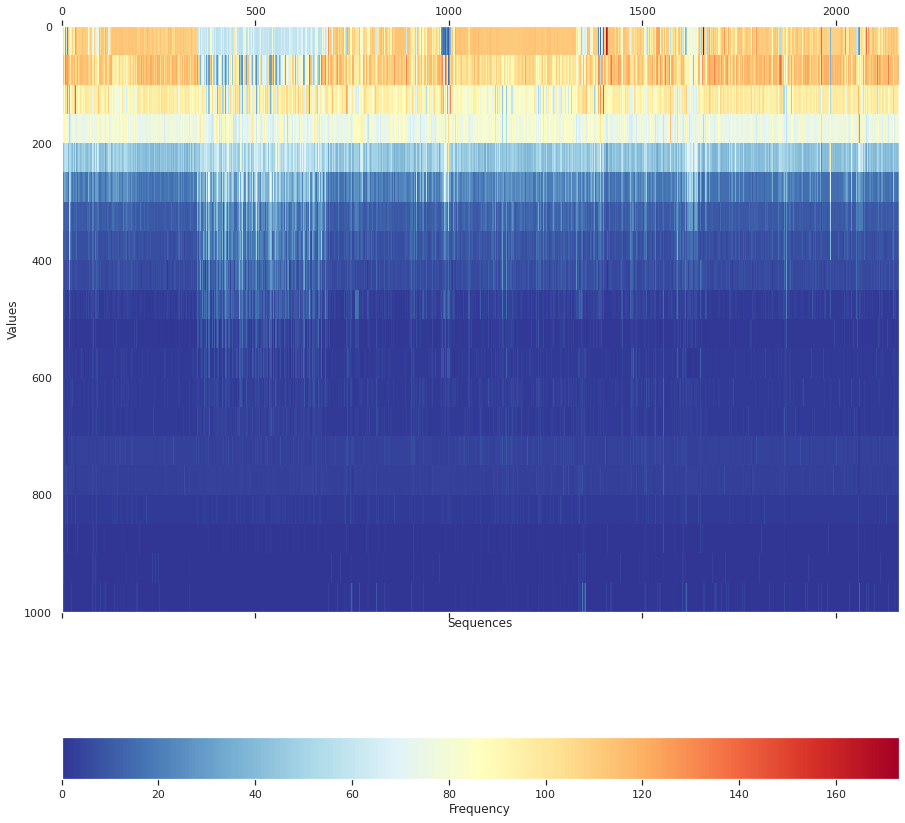

In [104]:
Nphase = 2162
Npoints = 500

phase = np.linspace(0.,1.,num=Nphase)

#calculate the bins we're going to use
minBin, maxBin = np.nanmin(stacked_tensor_flat2)*1000,np.nanmax(stacked_tensor_flat2*1000)
Nbins = 20

binedData = np.zeros((Nphase,Nbins))
for i,a in enumerate(stacked_tensor_flat2*1000):
    binedData[i,:], bins = np.histogram(a[~np.isnan(a)],bins=Nbins,range=(minBin,maxBin))

plt.figure(figsize=(15,15))
plt.matshow(binedData.T, cmap=plt.cm.RdYlBu_r, extent=(0,Nphase,maxBin,minBin), fignum=1, aspect='auto')

plt.grid(False)
c = plt.colorbar(orientation='horizontal')
plt.xlabel('Sequences')
plt.ylabel('Values')
c.set_label('Frequency')
plt.show()

In [105]:
#stack_all = torch.cat((stacked_tensor_flat, stacked_tensor_flat2), 1)
stack_all = stacked_tensor_flat + stacked_tensor_flat2

(array([[ 9.,  6., 82., ...,  2.,  0.,  0.],
        [11., 19., 84., ...,  2.,  1.,  0.],
        [ 6., 21., 86., ...,  2.,  1.,  4.],
        ...,
        [ 6., 30., 94., ...,  8.,  3.,  4.],
        [ 7., 13., 85., ...,  7.,  0.,  0.],
        [ 8.,  9., 79., ...,  1.,  0.,  0.]]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 2162 Lists of Patches objects>)

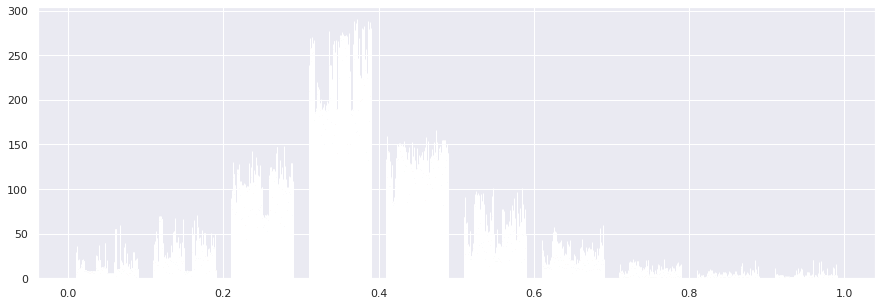

In [111]:
# Normalize
scaler = MinMaxScaler() 
stack_all = scaler.fit_transform(stack_all)
stack_all = torch.tensor(stack_all)
plt.hist(stack_all)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:27.)
  if sys.path[0] == '':


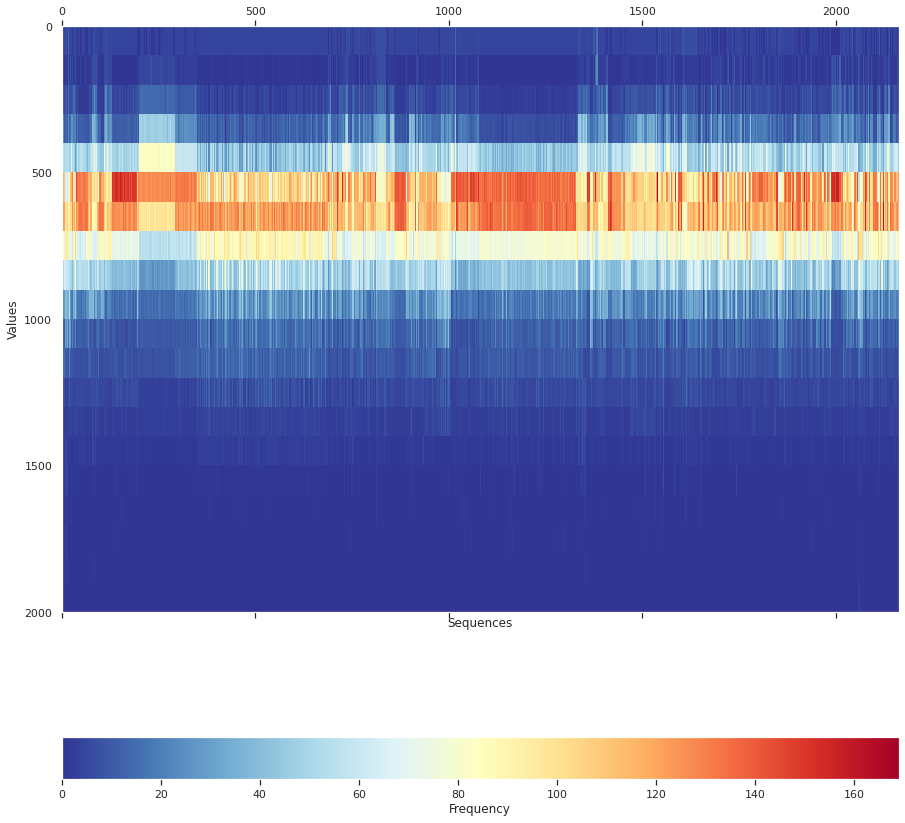

In [106]:
Nphase = 2162
Npoints = 500

phase = np.linspace(0.,1.,num=Nphase)

#calculate the bins we're going to use
minBin, maxBin = np.nanmin(stack_all)*1000,np.nanmax(stack_all*1000)
Nbins = 20

binedData = np.zeros((Nphase,Nbins))
for i,a in enumerate(stack_all*1000):
    binedData[i,:], bins = np.histogram(a[~np.isnan(a)],bins=Nbins,range=(minBin,maxBin))

plt.figure(figsize=(15,15))
plt.matshow(binedData.T, cmap=plt.cm.RdYlBu_r, extent=(0,Nphase,maxBin,minBin), fignum=1, aspect='auto')

plt.grid(False)
c = plt.colorbar(orientation='horizontal')
plt.xlabel('Sequences')
plt.ylabel('Values')
c.set_label('Frequency')
plt.show()

In [107]:
dataset = DWithInd(stack_all, torch.from_numpy(dif_mut['label'].values))
# run all computations on the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Running computations with %s' % torch.device(device))
if torch.cuda.is_available():
    print(torch.cuda.get_device_properties(device))

Running computations with cuda
_CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)


--------------------------------
FOLD 0
--------------------------------
Begin training.


  0%|          | 0/200 [00:00<?, ?it/s]

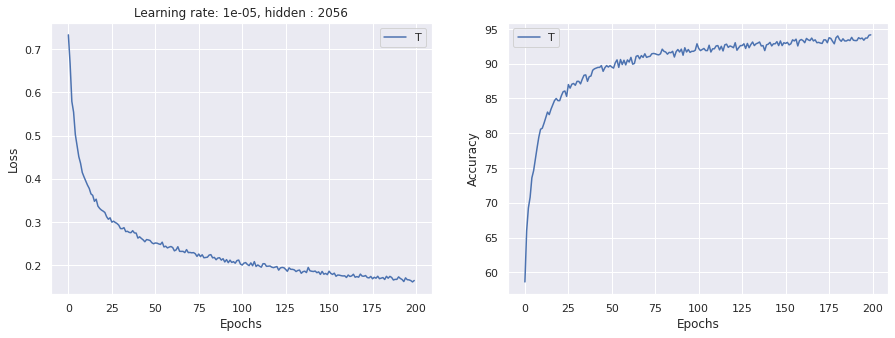

Accuracy for fold 0: 84 %
--------------------------------
FOLD 1
--------------------------------
Begin training.


  0%|          | 0/200 [00:00<?, ?it/s]

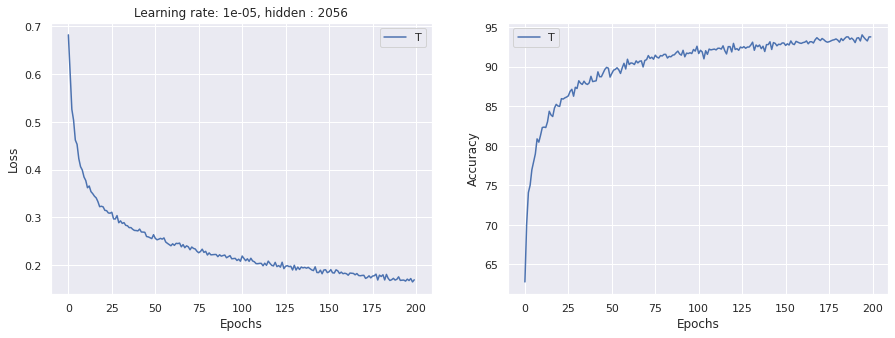

Accuracy for fold 1: 85 %
--------------------------------
FOLD 2
--------------------------------
Begin training.


  0%|          | 0/200 [00:00<?, ?it/s]

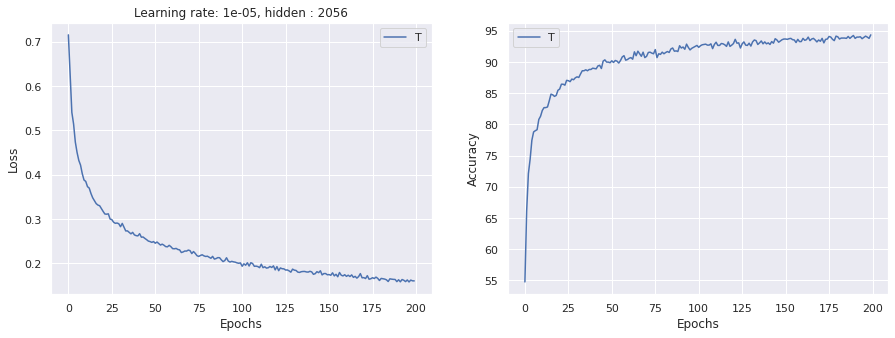

Accuracy for fold 2: 81 %
--------------------------------
FOLD 3
--------------------------------
Begin training.


  0%|          | 0/200 [00:00<?, ?it/s]

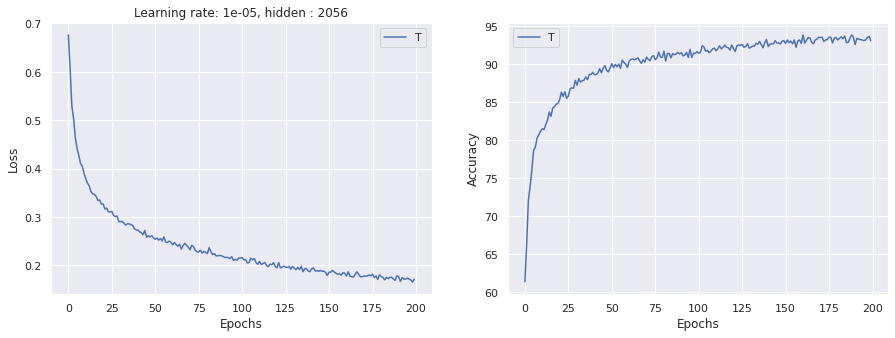

Accuracy for fold 3: 87 %
--------------------------------
FOLD 4
--------------------------------
Begin training.


  0%|          | 0/200 [00:00<?, ?it/s]

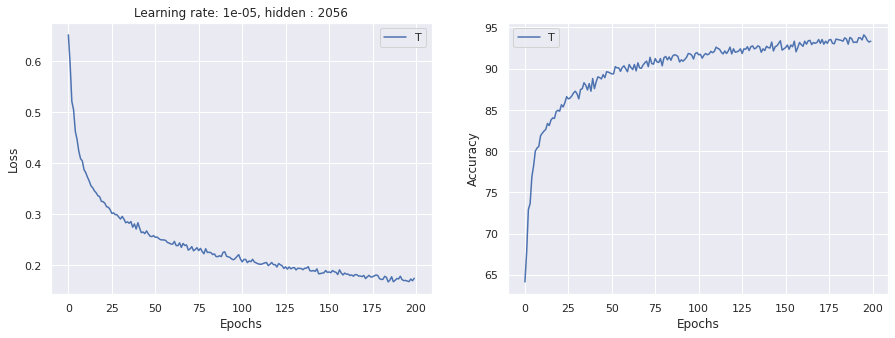

Accuracy for fold 4: 89 %
--------------------------------
FOLD 5
--------------------------------
Begin training.


  0%|          | 0/200 [00:00<?, ?it/s]

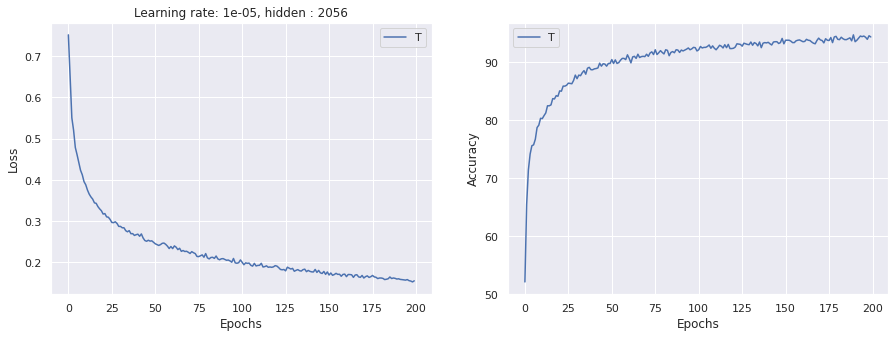

Accuracy for fold 5: 82 %
--------------------------------
FOLD 6
--------------------------------
Begin training.


  0%|          | 0/200 [00:00<?, ?it/s]

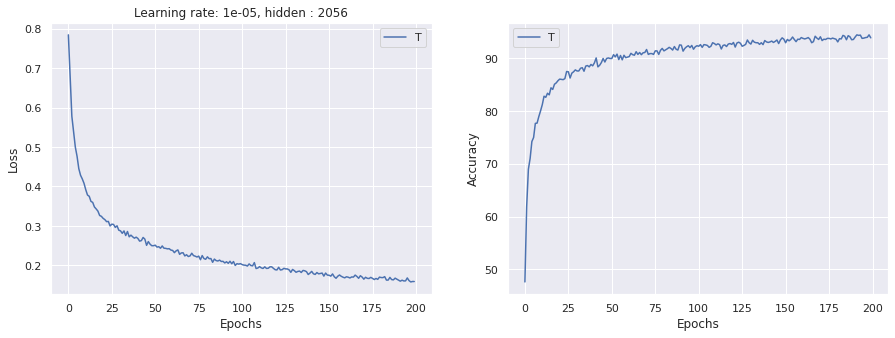

Accuracy for fold 6: 83 %
--------------------------------
FOLD 7
--------------------------------
Begin training.


  0%|          | 0/200 [00:00<?, ?it/s]

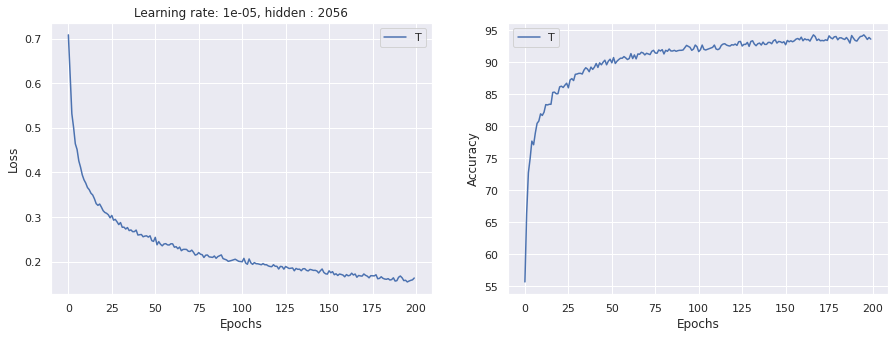

Accuracy for fold 7: 82 %
--------------------------------
FOLD 8
--------------------------------
Begin training.


  0%|          | 0/200 [00:00<?, ?it/s]

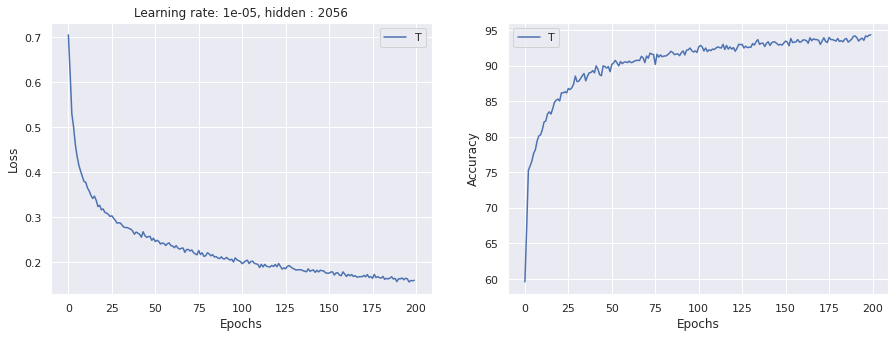

Accuracy for fold 8: 84 %
--------------------------------
FOLD 9
--------------------------------
Begin training.


  0%|          | 0/200 [00:00<?, ?it/s]

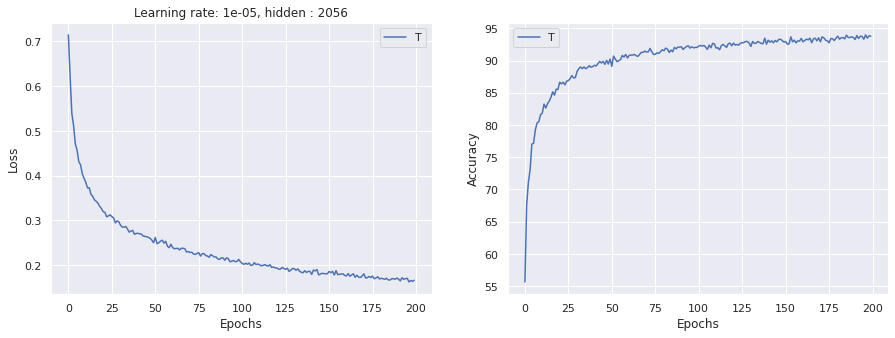

Accuracy for fold 9: 85 %
--------------------------------
K-FOLD CROSS VALIDATION RESULTS FOR 10 FOLDS
--------------------------------
Accuracy:
Fold 0: 84.0 %
Fold 1: 86.0 %
Fold 2: 81.0 %
Fold 3: 87.0 %
Fold 4: 90.0 %
Fold 5: 82.0 %
Fold 6: 83.0 %
Fold 7: 82.0 %
Fold 8: 84.0 %
Fold 9: 85.0 %
Average: 85.0 %

Sensitivity:
Fold 0:  84.43  %
Fold 1:  87.7  %
Fold 2:  79.51  %
Fold 3:  86.89  %
Fold 4:  89.34  %
Fold 5:  86.07  %
Fold 6:  78.69  %
Fold 7:  83.61  %
Fold 8:  83.47  %
Fold 9:  88.43  %
Average: 84.81 %

Specificity:
Fold 0: 84.21  %
Fold 1: 83.16  %
Fold 2: 82.98  %
Fold 3: 87.23  %
Fold 4: 90.43  %
Fold 5: 77.66  %
Fold 6: 89.36  %
Fold 7: 80.85  %
Fold 8: 85.26  %
Fold 9: 81.05  %
Average: 84.22 %
Matthews_corrcoef:
Fold 0: 0.68  %
Fold 1: 0.71  %
Fold 2: 0.62  %
Fold 3: 0.74  %
Fold 4: 0.79  %
Fold 5: 0.64  %
Fold 6: 0.67  %
Fold 7: 0.64  %
Fold 8: 0.68  %
Fold 9: 0.7  %
Average: 0.69 %


In [108]:
# Configurationh options
k_folds = 10
BATCH_SIZE = 64
#loss_function = nn.CrossEntropyLoss()
loss_function = nn.BCEWithLogitsLoss()

# For fold results
results, sensitivity, specificity, mcc = {}, {}, {}, {}

# Set fixed random number seed
torch.manual_seed(42)

# Define the K-fold Cross Validator
kfold = StratifiedKFold(n_splits=k_folds, shuffle=True)
  
# Start print
print('--------------------------------')

# K-fold Cross Validation model evaluation
for fold, (train_ids, test_ids) in enumerate(kfold.split(stack_all, dif_mut['label'].to_numpy())):
  
  # Print
  print(f'FOLD {fold}')
  print('--------------------------------')
  
  # Sample elements randomly from a given list of ids, no replacement.
  train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
  test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
  
  # Define data loaders for training and testing data in this fold
  trainloader = torch.utils.data.DataLoader(
                    dataset, 
                    batch_size=BATCH_SIZE, sampler=train_subsampler)
  testloader = torch.utils.data.DataLoader(
                    dataset,
                    batch_size=BATCH_SIZE, sampler=test_subsampler)
  
  epochs =200
  warmup = 0.2
  learning_rate = 0.00001
  hidden= 2056

  my_net = Classifier(hidden, 0.2).to(device)
  my_net.apply(init_weights)

  optimizer = optim.AdamW(my_net.parameters(), lr=learning_rate)#, weight_decay=0.001)
  total_steps = len(stacked_tensor_flat)/BATCH_SIZE
  warmup_steps = math.floor(total_steps * warmup)
  warmup_steps = math.floor(total_steps * warmup)
  scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)

  loss, acc = train_net(my_net, trainloader, loss_fn, optimizer, epochs,scheduler)


  plt.rcParams["figure.figsize"] = (15,5)
  sns.set()
  # plot train/validation loss curves
  plt.subplot(1, 2, 1)
  plt.plot(loss)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title(f'Learning rate: {learning_rate}, hidden : {hidden}')
  plt.legend(('Train'))
  #plt.title(f'Learning rate: {lr}, hidden : {h}, hidden2: {h2}')

  plt.subplot(1, 2, 2)
  plt.plot(acc)
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(('Train'))
  plt.show()

  correct, total = 0, 0
  outputs_fold, targets_fold =[], []

  my_net.eval()
  with torch.no_grad():

    # Iterate over the test data and generate predictions
    for i, data in enumerate(testloader, 0):
     
      # Get inputs
      inputs, targets, ind = data
      
      if(train_on_gpu):
        inputs, targets, ind = inputs.cuda(), targets.cuda(), ind.cuda()
      # Generate outputs
      outputs = my_net(inputs.float())
      outputs_fold.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
      targets_fold.extend(targets.cpu().detach().numpy().tolist())

      # Set total and correct
      #_, predicted = torch.max(outputs.data, 1)

      #print(torch.round(torch.sigmoid(outputs)))
      #print('Targets:', targets)
      total += targets.size(0)
      #correct += (torch.round(torch.sigmoid(outputs)) == targets).sum().item()
      outputs_round = torch.round(torch.sigmoid(outputs))
      #print('Predictions:', outputs_round)
      correct += (outputs_round.eq(targets.float().view_as(outputs_round))).sum()

    # Print accuracy
    print('Accuracy for fold %d: %d %%' % (fold, 100.0 * correct / total))
    print('--------------------------------')
    results[fold] = 100.0 * (correct / total)

    flat_list = []
    for sublist in outputs_fold:
        for item in sublist:
            flat_list.append(item)

    predictions = [1 if i>0.5 else 0 for i in flat_list]
    confusion_matrix_df = pd.DataFrame(confusion_matrix(targets_fold, predictions))
    tn, fp, fn, tp = confusion_matrix(targets_fold, predictions).ravel()

    #print(classification_report(targets_fold, predictions))
    #print(tp, tn, fp, fn )

    TPR =tp / (tp + fn)
    #print('Sensitivity: %.2f'  % (TPR*100))
    sensitivity[fold] = TPR*100

    TNR = tn / (tn + fp)
    #print('Specificity: %.2f'  % (TNR*100))
    specificity[fold] = TNR*100

    #mcc[fold] =matthews_corrcoef(targets.cpu(), outputs_round.cpu())
    mcc[fold] =matthews_corrcoef(targets_fold, predictions)
  
# Print fold results
print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
print('--------------------------------')
print('Accuracy:')
sum = 0.0
for key, value in results.items():
  print(f'Fold {key}: {torch.round(value)} %')
  sum += value
print(f'Average: {torch.round(sum/len(results.items()))} %\n')

print('Sensitivity:')
sum = 0.0
for key, value in sensitivity.items():
  print(f'Fold {key}:  {round(value, 2)}  %')
  sum += value
print(f'Average: {round(sum/len(results.items()),2)} %\n')

print('Specificity:')
sum = 0.0
for key, value in specificity.items():
  print(f'Fold {key}: {round(value, 2)}  %')
  sum += value
print(f'Average: {round(sum/len(results.items()),2)} %')

print('Matthews_corrcoef:')
sum = 0.0
for key, value in mcc.items():
  print(f'Fold {key}: {round(value, 2)}  %')
  sum += value
print(f'Average: {round(sum/len(results.items()),2)} %')

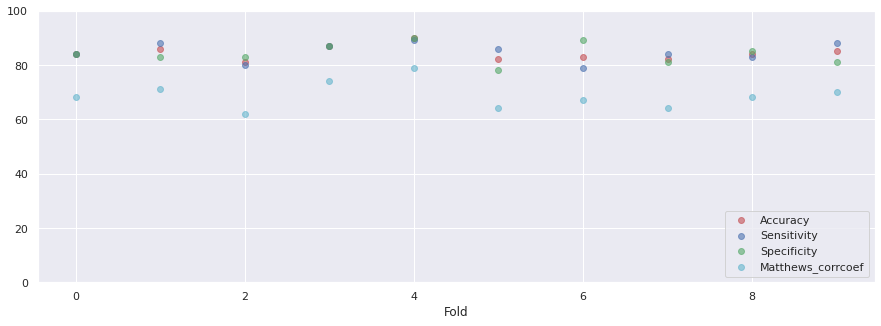

In [109]:
# line plot of k mean values with min/max error bars
folds = range(0,10)
plt.rcParams["figure.figsize"] = (15,5)
sns.set()

#plt.errorbar(folds, means, fmt='o')
# plot the ideal case in a separate color
plt.scatter(folds, [torch.round(value).cpu() for key, value in results.items()], alpha = 0.6, color='r', label = 'Accuracy')
plt.scatter(folds, [round(value) for key, value in sensitivity.items()],alpha = 0.6, color='b', label = 'Sensitivity')
plt.scatter(folds, [round(value) for key, value in specificity.items()], alpha = 0.6,color='g', label = 'Specificity')
plt.scatter(folds, [round(value*100) for key, value in mcc.items()], alpha = 0.6,color='c', label = 'Matthews_corrcoef')
plt.xlabel('Fold')
plt.ylim(0,100)
plt.legend(loc="lower right")
# show the plot
plt.show()

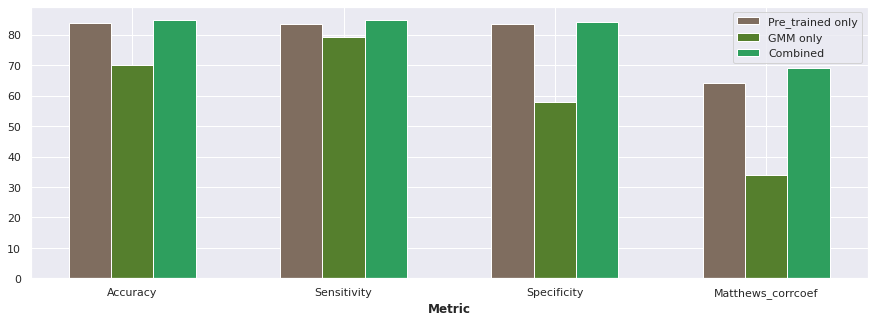

In [110]:
# set width of bars
barWidth = 0.2
 
# set heights of bars
bars1 = [ 84, 83.5, 83.59, 64]
bars2 =[70,  79.39,  58.05,  34 ]
bars3=[85, 84.81,  84.22 , 69  ]
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# Make the plot
plt.bar(r1, bars1, color='#7f6d5f', width=barWidth, edgecolor='white', label='Pre_trained only')
plt.bar(r2, bars2, color='#557f2d', width=barWidth, edgecolor='white', label='GMM only')
plt.bar(r3, bars3, color='#2e9f5e', width=barWidth, edgecolor='white', label='Combined')

 
# Add xticks on the middle of the group bars
plt.xlabel('Metric', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ['Accuracy', 'Sensitivity', 'Specificity', 'Matthews_corrcoef'])
 
# Create legend & Show graphic
plt.legend()
plt.show()

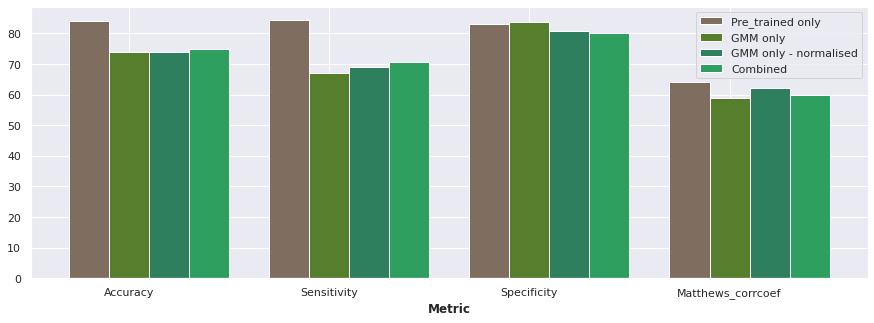

In [ ]:
# set width of bars
barWidth = 0.2
 
# set heights of bars
bars1 = [ 84, 84.48, 83.16, 64]
bars2 =[74,  67.17,  83.8,  59]
bars3 =[74,  69.14,  80.85,  62]
bars4=[75, 70.78,  80.19 , 60 ]
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
 
# Make the plot
plt.bar(r1, bars1, color='#7f6d5f', width=barWidth, edgecolor='white', label='Pre_trained only')
plt.bar(r2, bars2, color='#557f2d', width=barWidth, edgecolor='white', label='GMM only')
plt.bar(r3, bars3, color='#2d7f5e', width=barWidth, edgecolor='white', label='GMM only - normalised')
plt.bar(r4, bars4, color='#2e9f5e', width=barWidth, edgecolor='white', label='Combined')

 
# Add xticks on the middle of the group bars
plt.xlabel('Metric', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ['Accuracy', 'Sensitivity', 'Specificity', 'Matthews_corrcoef'])
 
# Create legend & Show graphic
plt.legend()
plt.show()

## Pre-Trained + GMM + RNN